In [1]:
%matplotlib inline
from pylab import *
import cv2
import rasterio

rcParams['figure.figsize'] = 10, 10

from dataset import load_image

import torch
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from utils import variable
from generate_masks import get_model
from unet_models import unet11_MS

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


# DEMO ALTERED. THESE CELLS GENERATE SOME DATA

In [2]:
# import the helper functions
from test_unet_helpers import *

import glob
import os,sys
from matplotlib import pyplot as plt
import numpy as np
from scipy import misc
import fiona
from shapely.geometry import shape
import shapely
from rasterio.mask import mask
from pyproj import Proj, transform

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
# specify scene id for DG data
dg_scene_id = '1030010057062200'

# specify image for 2.0 meter analysis
gt_image_2 = '../rasters/union_impervious_raster_2_0_0_wgs84.tif' # desktop

# specify images for 0.5 meter analysis
gt_image_05 = '../rasters/union_impervious_raster_0_5.tif' # desktop

# specify the shapefile
shpfile = '../union/union.shp' # desktop
rows = []
with fiona.open(shpfile) as shp:
    crs = shp.crs
    shp_bounds = shp.bounds

In [4]:
from gbdxtools import Interface, CatalogImage

# connect to gbdx
gbdx = Interface()

# get the dask array for the 8 band MS image
img_2m = CatalogImage(dg_scene_id, band_type='MS', bbox=shp_bounds, acomp=True)
rows, cols = img_2m.shape[1:]

# get the dask array for the Pansharpened, 4 band image
image_05m = CatalogImage(dg_scene_id, bbox=shp_bounds, acomp=True, pansharpen=True)
rowsP, colsP = image_05m.shape[1:]
pan_factorR = np.floor(rowsP/rows)
pan_factorC = np.floor(colsP/cols)

In [5]:
torch.cuda.device_count()

4

In [6]:
# generate the sample points
# we have some funny stuff from ArcGIS converting the polygons to a raster... so... 
# generate the points within the bounds of the shapefile / DG image array

import random

random.seed(10)

num = 10000
side = 64
coords = []
coords_pan = []
im_patches = []
im_patches_pan = []

with rasterio.open(gt_image_2, 'r') as src:
    
    for i in range(num):
        ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
        #print('generating sample {} of {}'.format(i+1, num))

        try:
            r_start = ran_row - side/2
            r_end = ran_row + side/2
            c_start = ran_col - side/2
            c_end = ran_col + side/2
            #im_data = img_2m[:, r_start:r_end, c_start:c_end]

            pr_start = ran_row*pan_factorR - side/2
            pr_end = ran_row*pan_factorR + side/2
            pc_start = ran_col*pan_factorC - side/2
            pc_end = ran_col*pan_factorC + side/2
            #im_data_pan = image_05m[:, pr_start:pr_end, pc_start:pc_end]

            # append regardless and check later.

            #############################################################################################################
            ### SHOULD CHECK THE INFORMATION THRESHOLDS BELOW, BUT HERE, TO RESELECT ROWS AND COLUMNS UNTIL IT IS MET ###
            #############################################################################################################

            s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
            pt_flag = checkWindow(src, s_pt)
            ct = 0
            while pt_flag:
                ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
                s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
                pt_flag = checkWindow(src, s_pt)
                
                ct+=1
                # exit loop after 1000 tries
                if ct > 1000:
                    break
            if ct > 1000:
                print('1000 tries, moving on')
                continue
                
                
            coords.append((ran_row, ran_col))
            coords_pan.append(( int(ran_row*pan_factorR), int(ran_col*pan_factorC)))

        except Exception as e:
            print(e)

    coords_arr = np.array(coords)  

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
lonlat_MS = [calcXYfromRC(img_2m.affine, pair) for pair in coords]
lonlat_PAN = [calcXYfromRC(image_05m.affine, pair) for pair in coords_pan]

In [8]:
import pyproj
       
def assignRC2(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    outProj = Proj(init=outproj)
    inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x2,y2)
    r,c = [int(c) for c in temp]
    
    return ((x3,y3), samp_pt, r,c)

def assignRC3(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    #outProj = Proj(init=outproj)
    #inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    #x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    #x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x1,y1)
    r,c = [int(c) for c in temp]
    
    return ((x1,y1), samp_pt, r,c)

# use the lonlats_* lists to sample the ground truth image. return the histogram if the window is on the border,
# which should be evident if the window extends across
with rasterio.open(gt_image_2, 'r') as src:
    #print(src.crs)

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_MS = [assignRC3(src, samp_pt) for samp_pt in lonlat_MS]

# do the same for the 0.5 meter ground truth raster
with rasterio.open(gt_image_05, 'r') as src:

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_PAN = [assignRC(src, samp_pt) for samp_pt in lonlat_MS]




In [9]:
# image transform for DG imagery
img_transform = Compose([
    Normalize(mean=[1545.9403, 1460.1287, 1452.7002, 1466.6466, 1511.6293, 1902.1776, 2497.181, 2167.458], 
              std=[512.423, 672.7396, 743.9062, 840.52625, 918.4014, 828.56976, 1196.6774, 1061.4962])
])

In [10]:
# for i in range(8):
#     print(img_2m[i,:,:].mean().compute(), img_2m[i,:,:].std().compute())

## Train the initial model with a subset of the sample points.. need to edit the source code to use the input data classes instead of data loaders.
### to use the dataloader, may need to create some attributes on the class such as self.__len__

In [11]:
val_test_percentage = 0.2
train_ind = int(num - num * val_test_percentage)
val_ind = int((num - train_ind)*0.5)
val_ind = train_ind + val_ind
train_ind, val_ind


(8000, 9000)

In [12]:
bsize = 100

## establish the data loaders
from torch.utils.data import DataLoader

# ground truth
gt_transform = Compose([
    ToTensor()
    ])
gt_dataset_train = gtDatasetSampler2(gt_image_2, coords[:train_ind], transform=gt_transform) 
# gt_dataset_train = gtDatasetSampler2(gt_image_2, coords[:1000], transform=gt_transform) # debug 
gt_dataset_val = gtDatasetSampler2(gt_image_2, coords[train_ind:val_ind], transform=gt_transform)
gt_dataset_test = gtDatasetSampler2(gt_image_2, coords[val_ind:], transform=gt_transform)

gt_dl_train = DataLoader(gt_dataset_train, batch_size=bsize, shuffle=False)
gt_dl_val = DataLoader(gt_dataset_val, batch_size=bsize, shuffle=False)


#DG
dg_dataset_train = DigitalGlobeSamplerTensor(img_2m, coords[:train_ind], transform=img_transform, comb='all') # will return RGB by default
# dg_dataset_train = DigitalGlobeSamplerTensor(img_2m, coords[:1000], transform=img_transform) # debug
dg_dataset_val = DigitalGlobeSamplerTensor(img_2m, coords[train_ind:val_ind], transform=img_transform, comb='all')
dg_dataset_test = DigitalGlobeSamplerTensor(img_2m, coords[val_ind:], transform=img_transform, comb='all')

dg_dl_train = DataLoader(dg_dataset_train, batch_size=bsize, shuffle=False)
dg_dl_val = DataLoader(dg_dataset_val, batch_size=bsize, shuffle=False)

In [13]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
        
args = {}
args['lr'] = 0.0001
args['n_epochs'] = 4
args['batch_size'] = bsize
args['root'] = 'runs/debug'
args['fold']=0
args['jaccard_weight'] = 1

# convert dict keys to objects and specify lr
args = objectview(args)
lr = args.lr

In [14]:
from datetime import datetime

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True))
    log.write('\n')
    log.flush()
    
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))



In [15]:
import utils as pyt_utils
from torch.optim import Adam
import torch.backends.cudnn as cudnn
from pathlib import Path
from validation import validation_binary
from loss import LossBinary
import json

# need to change this to DICE loss!
#loss = LossBinary(jaccard_weight=args.jaccard_weight)
#criterion = nn.CrossEntropyLoss()


cudnn.benchmark = True

root = Path(args.root)
root.mkdir(exist_ok=True, parents=True)
root.joinpath('params.json').write_text(
    json.dumps(vars(args), indent=True, sort_keys=True))

valid = validation_binary

num_classes=1

## TRY A LOCAL IMPLEMENTATION OF UNET

In [16]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=2, depth=5, wf=6, padding=False,
                 batch_norm=False, up_mode='upconv'):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(UNetConvBlock(prev_channels, 2**(wf+i),
                                                padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(UNetUpBlock(prev_channels, 2**(wf+i), up_mode,
                                            padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path)-1:
                blocks.append(x)
                x = F.avg_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i-1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2,
                                         stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2),
                                    nn.Conv2d(in_size, out_size, kernel_size=1))

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[:, :, diff_y:(diff_y + target_size[0]), diff_x:(diff_x + target_size[1])]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

In [ ]:
import time
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
# from sklearn.cross_validation import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split

## call outside training method, in loop

# iterate over some batch sizes
times = []
# batch_sizes = [50, 100, 200,300,400,500,600,700,800,900,1000]
bsize = 8 # smaller batch sizes as per https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network
model = unet11_MS(pretrained=False)
# model = UNet(in_channels=8, n_classes=1, padding=True)

# set some parameters
lr = 0.0001
optimizer = Adam(model.parameters(), lr=lr)
criterion = LossBinary(jaccard_weight=args.jaccard_weight)
# criterion = nn.BCELoss()

# make model parallel and on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
    model.to(device)

optimizer = Adam(model.parameters(), lr=lr)
criterion = LossBinary(jaccard_weight=args.jaccard_weight)
# criterion = nn.BCELoss()

print('batchsize, ', bsize)
mean_loss = 0.0
running_loss = 0.0
print('training...')

losses=[]
losses_ep = []
#tl = zip(dg_dl_train, gt_dl_train)
step=0


###### specify DataLoaders
## GT
## num_workers=0 seems to engage all GPUs when previously 4 worked
gt_dl_train = DataLoader(gt_dataset_train, batch_size=bsize, shuffle=False, num_workers=0)
gt_dl_val = DataLoader(gt_dataset_val, batch_size=bsize, shuffle=False, num_workers=0)


## DG
dg_dl_train = DataLoader(dg_dataset_train, batch_size=bsize, shuffle=False, num_workers=0)
dg_dl_val = DataLoader(dg_dataset_val, batch_size=bsize, shuffle=False, num_workers=0)

In [20]:
# record time for one epoch
rocs = []

In [21]:
t0 = time.time()
for epoch in range(1,100):
    
    try:
        te = time.time()

        epoch_i = epoch+1
        print('on epoch {}'.format(epoch_i))
        tl = zip(dg_dl_train, gt_dl_train) # this can't be defined outside the loop. This suggests it is...cashing out??
        for i, (inputs_, targets_) in enumerate(tl):

            # get the inputs
            #inputs, targets = variable(inputs_).cuda(), variable(targets_).cuda()
            inputs, targets = variable(inputs_), variable(targets_)
            inputs.to(device)
            targets.to(device)

            outputs = model(inputs)

            # zero parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize            
            i_loss = criterion(outputs, targets)                
            i_loss.backward()
            optimizer.step()
            step+=1


            if i%10 == 0: # print/store every 10
                losses.append(i_loss)
                #running_loss += i_loss
                #print('[%d, %5d] loss: %.3f' %(epoch, i + 1, i_loss))

        # get some numbers for the ROC curve
        if epoch_i%2 == 0:
            pred_y = outputs.cpu().data.numpy().squeeze().flatten()
            target_y = targets.cpu().data.numpy().flatten()
            tu = (i_loss, roc_auc_score(target_y,pred_y ))
            print ('epoch: {}, LOSS={}, ROC_AUC={} '.format(epoch_i, *tu))  

        losses_ep.append(losses)
        te1 = time.time()
        print('time for epoch {}: {} seconds'.format(epoch_i, te1-te))
        rocs.append(tu[1])
        
        # early exit criteria
        if len(rocs)>2:
            if (np.abs(rocs[-1] - rocs[-2]) < 0.009) and (rocs[-1] > 0.98):
                print('area under curve not changing significantly, exit loop')
                break_flag = True
                break
    
    except Exception as e:
        print('something happened')
        print(e)
        break
        
        
t1 = time.time()
print ('total time: ',t1 - t0)
times.append(t1-t0)

on epoch 2


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch: 2, LOSS=1.5450658798217773, ROC_AUC=0.6031025119533326 
time for epoch 2: 550.927750825882 seconds
on epoch 3
time for epoch 3: 544.504497051239 seconds
on epoch 4
epoch: 4, LOSS=1.5193569660186768, ROC_AUC=0.6259652914257576 
time for epoch 4: 542.1705281734467 seconds
on epoch 5
time for epoch 5: 539.023588180542 seconds
on epoch 6
epoch: 6, LOSS=1.4927878379821777, ROC_AUC=0.6323329576650546 
time for epoch 6: 544.9700479507446 seconds
on epoch 7
time for epoch 7: 543.1933197975159 seconds
on epoch 8
epoch: 8, LOSS=1.4371556043624878, ROC_AUC=0.6595570176711969 
time for epoch 8: 550.2457518577576 seconds
on epoch 9
time for epoch 9: 545.2433779239655 seconds
on epoch 10
epoch: 10, LOSS=1.4152954816818237, ROC_AUC=0.6746455677704059 
time for epoch 10: 542.514360666275 seconds
on epoch 11
time for epoch 11: 541.8089454174042 seconds
on epoch 12
epoch: 12, LOSS=1.3882179260253906, ROC_AUC=0.681391841145386 
time for epoch 12: 545.9765591621399 seconds
on epoch 13
time for epoc

time for epoch 95: 544.0197298526764 seconds
on epoch 96
epoch: 96, LOSS=1.2939434051513672, ROC_AUC=0.6986379745877228 
time for epoch 96: 546.6506714820862 seconds
on epoch 97
time for epoch 97: 543.6293408870697 seconds
on epoch 98
epoch: 98, LOSS=1.2915245294570923, ROC_AUC=0.6984724888642125 
time for epoch 98: 541.7581558227539 seconds
on epoch 99
time for epoch 99: 539.1164445877075 seconds
on epoch 100
epoch: 100, LOSS=1.2926719188690186, ROC_AUC=0.6970935397541517 
time for epoch 100: 545.4660470485687 seconds
total time:  53850.56116819382


In [22]:
# encoder = models.vgg11(pretrained=False).features
# encoder[0]

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


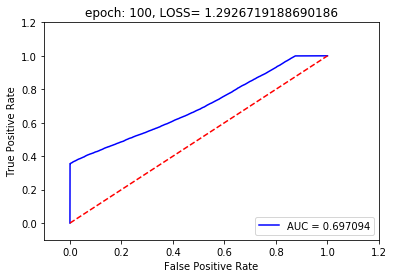

In [23]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y,pred_y)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('epoch: {}, LOSS= {}'.format(epoch_i, i_loss))
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Performance on the Validation set

In [24]:
model.eval()

DataParallel(
  (module): UNet11_MS(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ReLU(inplace)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace)
      (13): Conv2d(512, 512, kernel_siz

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Validation batch: 0, LOSS=1.477426528930664, ROC_AUC=0.7834071701024407 


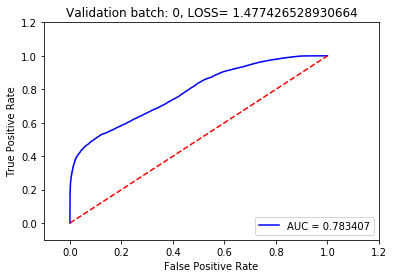

Validation batch: 1, LOSS=1.1814610958099365, ROC_AUC=0.8087227870804041 


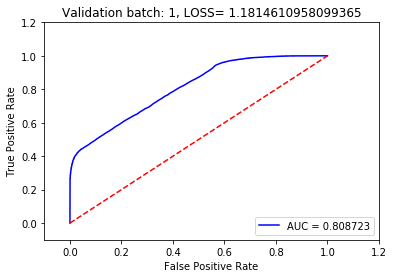

Validation batch: 2, LOSS=1.1027172803878784, ROC_AUC=0.6632594808696562 


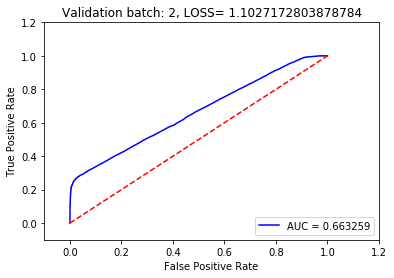

Validation batch: 3, LOSS=1.2382595539093018, ROC_AUC=0.7829587343929572 


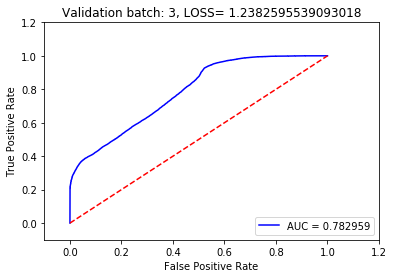

Validation batch: 4, LOSS=0.9768106937408447, ROC_AUC=0.7598388108625882 


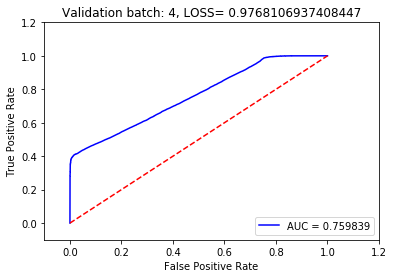

Validation batch: 5, LOSS=1.6063361167907715, ROC_AUC=0.6775205350101584 


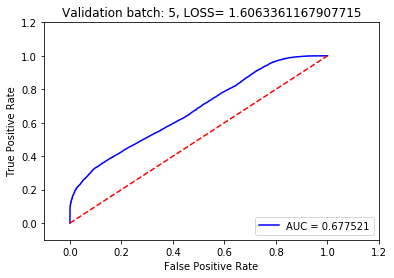

Validation batch: 6, LOSS=1.6063976287841797, ROC_AUC=0.664708046801848 


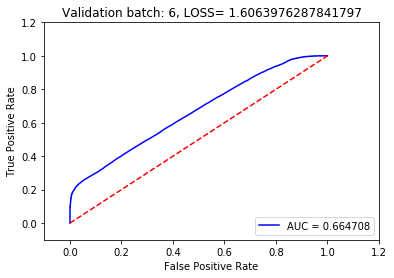

Validation batch: 7, LOSS=0.9345347881317139, ROC_AUC=0.7531501917310576 


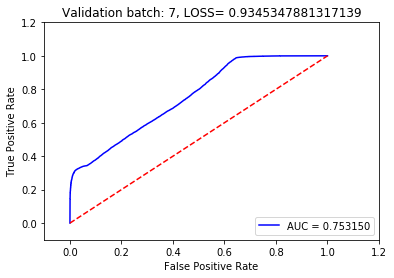

Validation batch: 8, LOSS=1.778917908668518, ROC_AUC=0.7958264699874058 


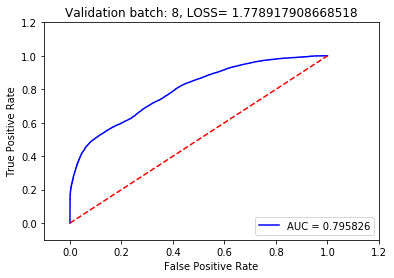

Validation batch: 9, LOSS=1.2898941040039062, ROC_AUC=0.84198678538588 


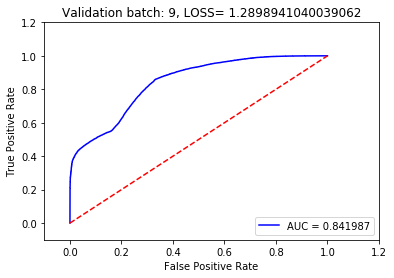

Validation batch: 10, LOSS=1.4667915105819702, ROC_AUC=0.7481012849039104 


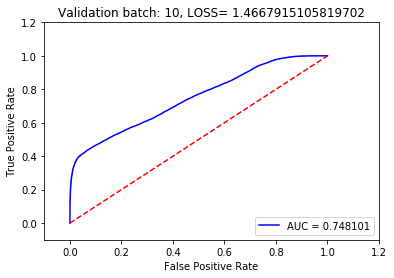

Validation batch: 11, LOSS=1.2209469079971313, ROC_AUC=0.7507212433276584 


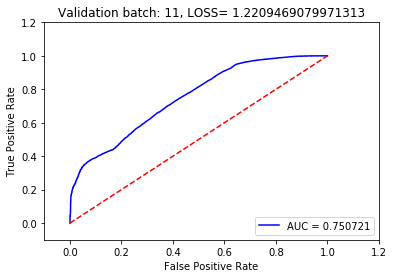

Validation batch: 12, LOSS=2.0430541038513184, ROC_AUC=0.6827176601587599 


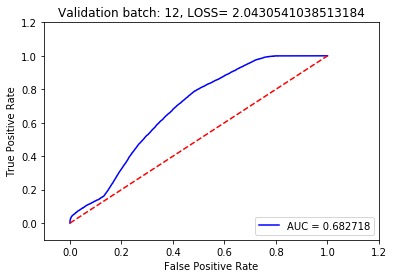

Validation batch: 13, LOSS=1.0876556634902954, ROC_AUC=0.8385926984675354 


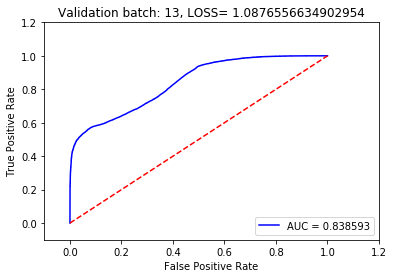

Validation batch: 14, LOSS=1.5948092937469482, ROC_AUC=0.8567085707484559 


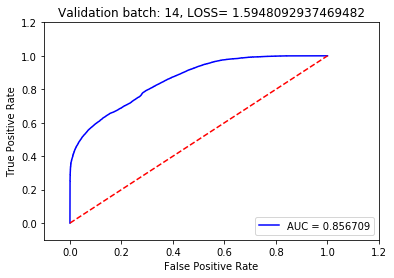

Validation batch: 15, LOSS=1.481003761291504, ROC_AUC=0.7850024529976547 


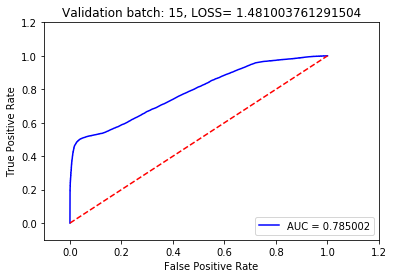

Validation batch: 16, LOSS=2.376713275909424, ROC_AUC=0.6746832990194279 


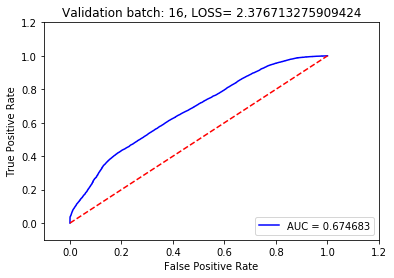

Validation batch: 17, LOSS=1.7735222578048706, ROC_AUC=0.7518405915176203 


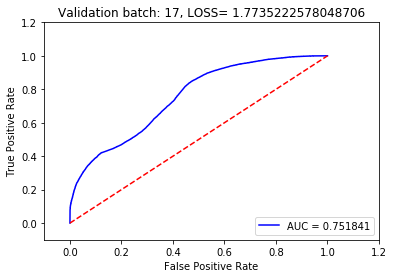

Validation batch: 18, LOSS=1.4524505138397217, ROC_AUC=0.7539778826428187 


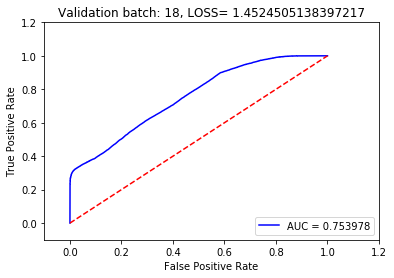

Validation batch: 19, LOSS=1.465450644493103, ROC_AUC=0.7794684201218622 


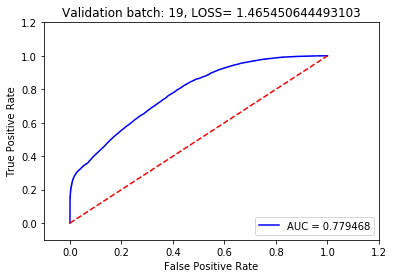

Validation batch: 20, LOSS=1.4387286901474, ROC_AUC=0.8633859504770696 


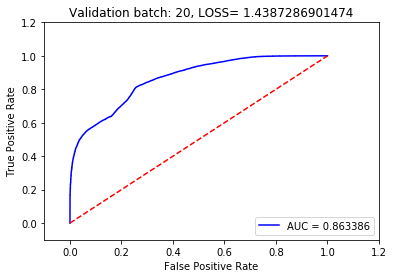

Validation batch: 21, LOSS=1.1606355905532837, ROC_AUC=0.7538510355782149 


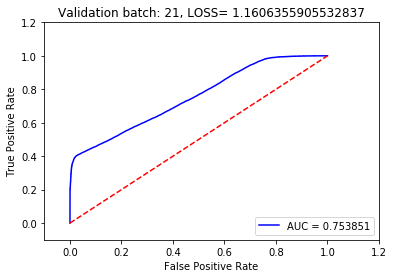

Validation batch: 22, LOSS=1.6229442358016968, ROC_AUC=0.8147604979129421 


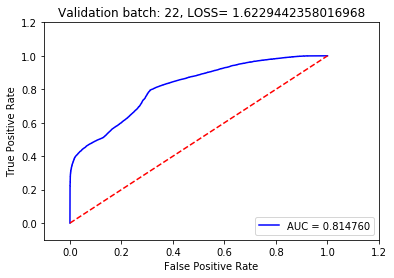

Validation batch: 23, LOSS=1.841660737991333, ROC_AUC=0.738581569540065 


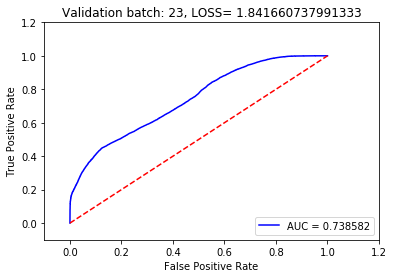

Validation batch: 24, LOSS=1.6529252529144287, ROC_AUC=0.63430485656411 


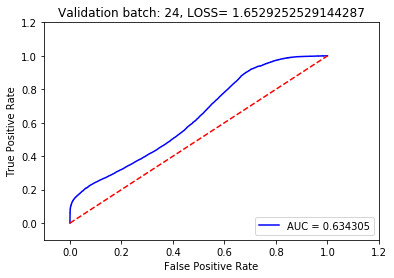

Validation batch: 25, LOSS=1.2169246673583984, ROC_AUC=0.7332929709881819 


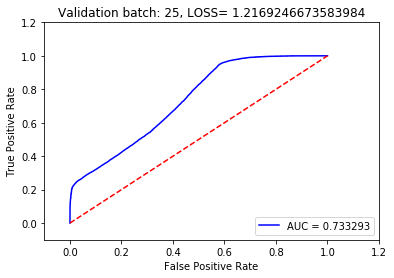

Validation batch: 26, LOSS=1.2829822301864624, ROC_AUC=0.7895891033754469 


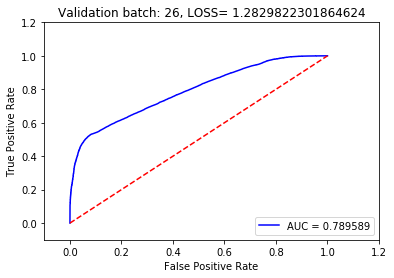

Validation batch: 27, LOSS=1.470758080482483, ROC_AUC=0.7836461608464969 


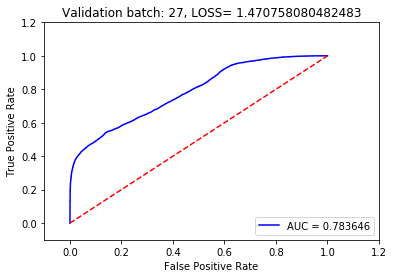

Validation batch: 28, LOSS=1.6966359615325928, ROC_AUC=0.7646228716241186 


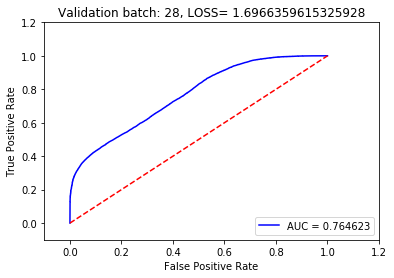

Validation batch: 29, LOSS=1.2831323146820068, ROC_AUC=0.7861549319085162 


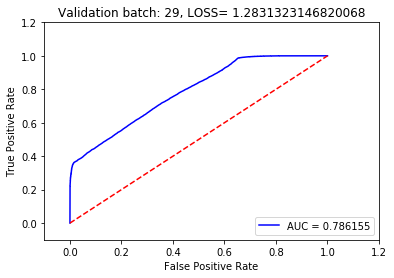

Validation batch: 30, LOSS=1.5380815267562866, ROC_AUC=0.8315719236049737 


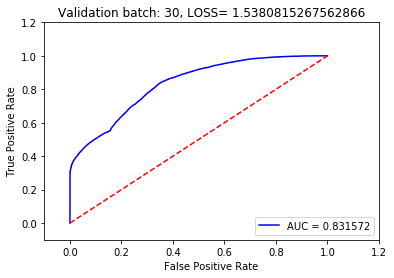

Validation batch: 31, LOSS=1.320955753326416, ROC_AUC=0.7821003145091592 


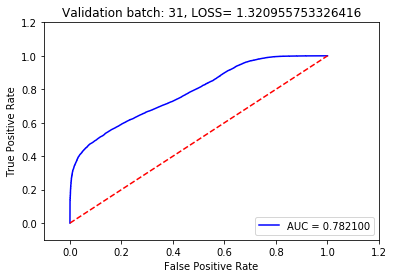

Validation batch: 32, LOSS=1.4941498041152954, ROC_AUC=0.8365037840393048 


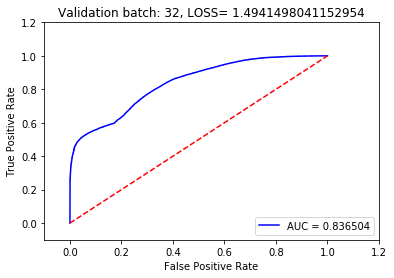

Validation batch: 33, LOSS=1.531472086906433, ROC_AUC=0.7836239316851021 


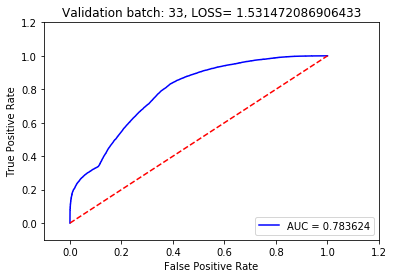

Validation batch: 34, LOSS=0.9721196889877319, ROC_AUC=0.9123909081971731 


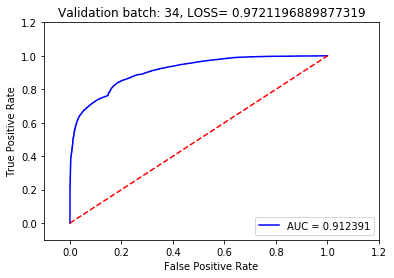

Validation batch: 35, LOSS=1.3047423362731934, ROC_AUC=0.882182501361036 


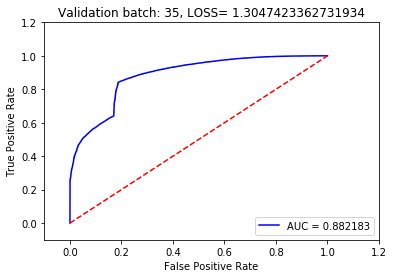

Validation batch: 36, LOSS=1.3015704154968262, ROC_AUC=0.8673426625862839 


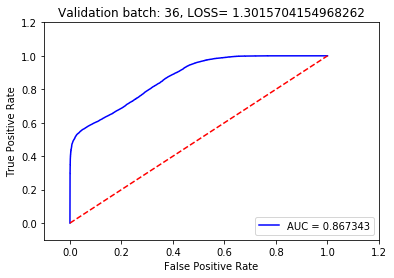

Validation batch: 37, LOSS=1.0733692646026611, ROC_AUC=0.8609919490564449 


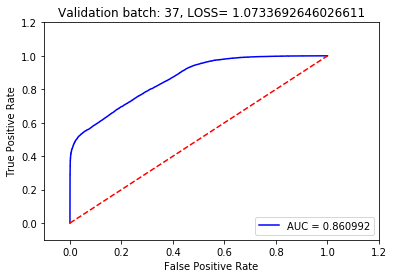

Validation batch: 38, LOSS=1.725927472114563, ROC_AUC=0.6858479796817198 


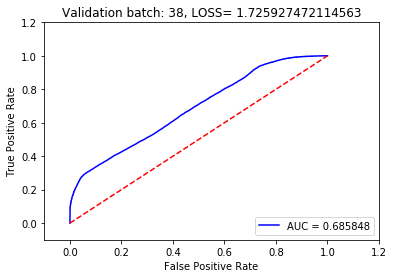

Validation batch: 39, LOSS=1.2925267219543457, ROC_AUC=0.7787734100033026 


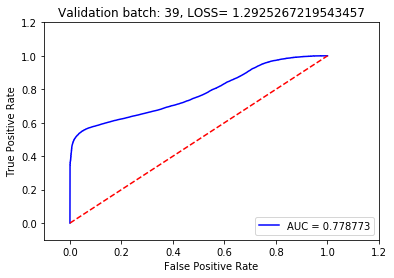

Validation batch: 40, LOSS=1.5294603109359741, ROC_AUC=0.7134609141369936 


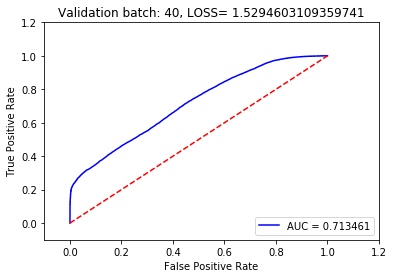

Validation batch: 41, LOSS=2.160284996032715, ROC_AUC=0.5835158793481123 


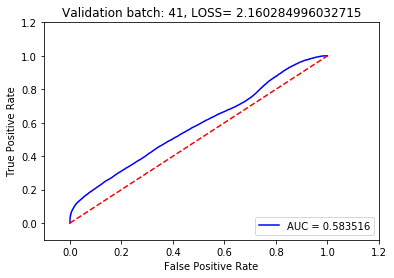

Validation batch: 42, LOSS=1.497817873954773, ROC_AUC=0.7711209754661342 


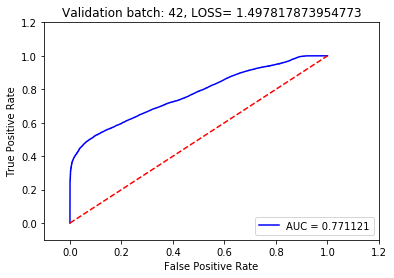

Validation batch: 43, LOSS=1.3401612043380737, ROC_AUC=0.7667110427855023 


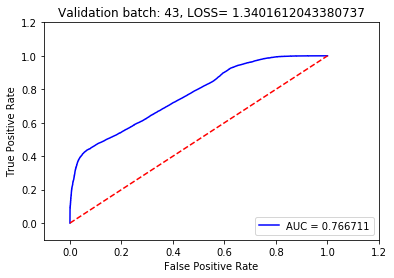

Validation batch: 44, LOSS=1.4292333126068115, ROC_AUC=0.8271325500430675 


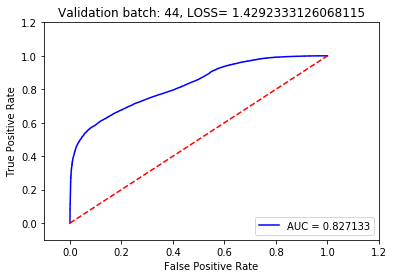

Validation batch: 45, LOSS=1.5472378730773926, ROC_AUC=0.7545579033123194 


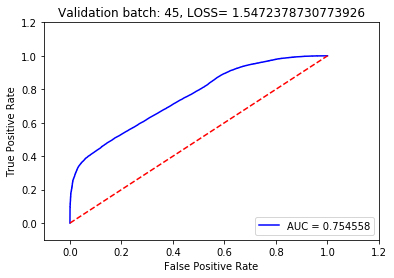

Validation batch: 46, LOSS=1.8202104568481445, ROC_AUC=0.7149252126251857 


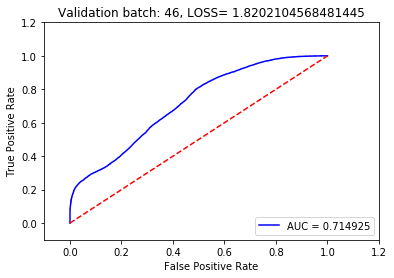

Validation batch: 47, LOSS=1.9336779117584229, ROC_AUC=0.7524288097998351 


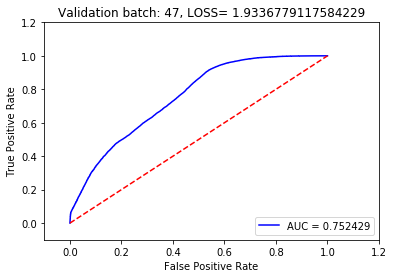

Validation batch: 48, LOSS=1.585482120513916, ROC_AUC=0.7213073866980222 


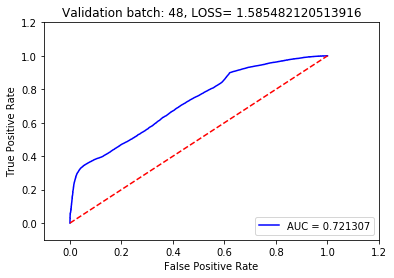

Validation batch: 49, LOSS=1.432084560394287, ROC_AUC=0.6177462755405871 


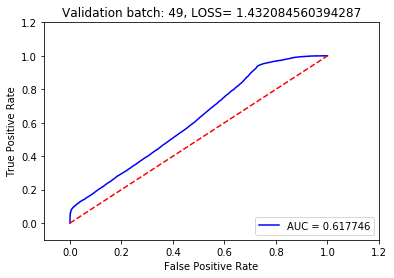

Validation batch: 50, LOSS=1.5372016429901123, ROC_AUC=0.7950027136074393 


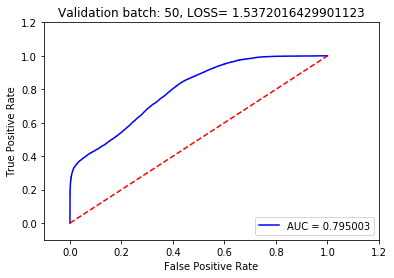

Validation batch: 51, LOSS=1.3781276941299438, ROC_AUC=0.7030757689744842 


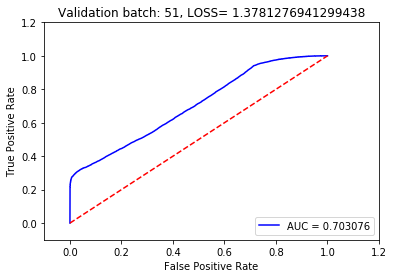

Validation batch: 52, LOSS=1.1716251373291016, ROC_AUC=0.7482000590144022 


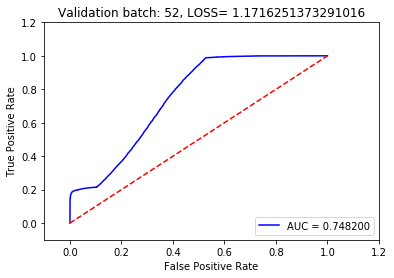

Validation batch: 53, LOSS=1.843400239944458, ROC_AUC=0.772222351778892 


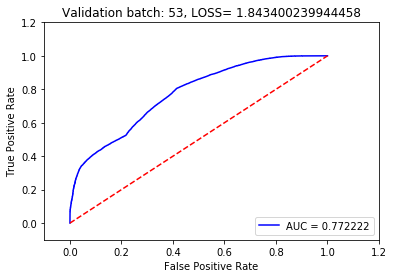

Validation batch: 54, LOSS=1.8363008499145508, ROC_AUC=0.7670191151978093 


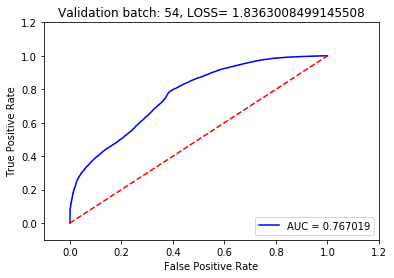

Validation batch: 55, LOSS=1.6980117559432983, ROC_AUC=0.7407365121083082 


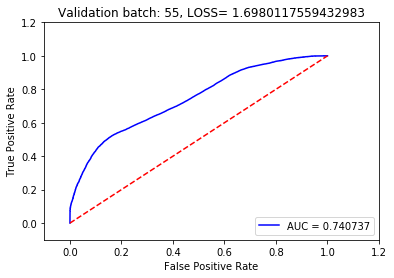

Validation batch: 56, LOSS=1.291860580444336, ROC_AUC=0.7282937299964319 


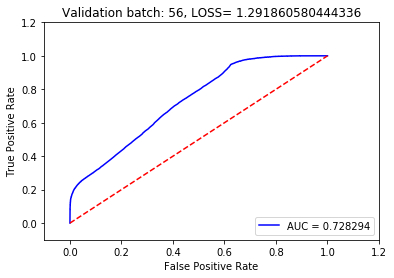

Validation batch: 57, LOSS=1.1134178638458252, ROC_AUC=0.9035164473921886 


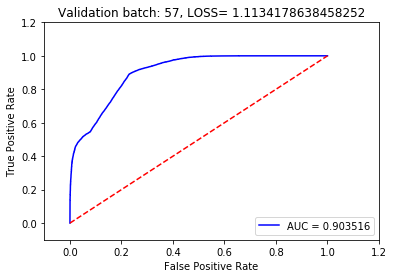

Validation batch: 58, LOSS=1.3670122623443604, ROC_AUC=0.7528197214016424 


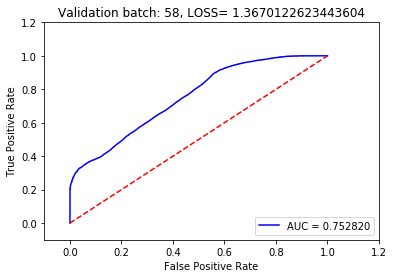

Validation batch: 59, LOSS=1.824437141418457, ROC_AUC=0.7584231434250608 


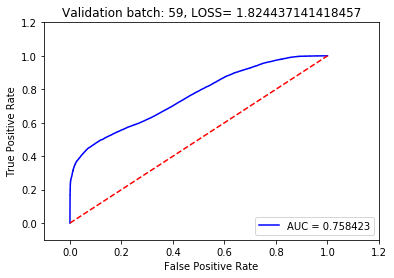

Validation batch: 60, LOSS=1.7990410327911377, ROC_AUC=0.7642726466776124 


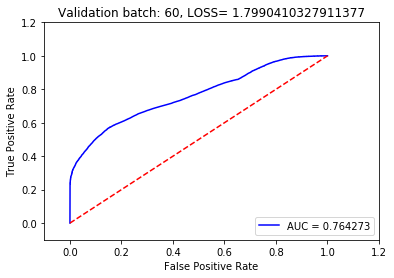

Validation batch: 61, LOSS=1.1665376424789429, ROC_AUC=0.8675183643044133 


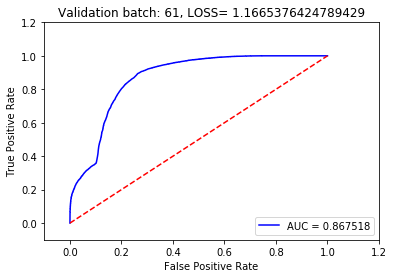

Validation batch: 62, LOSS=1.2230191230773926, ROC_AUC=0.8552006353560346 


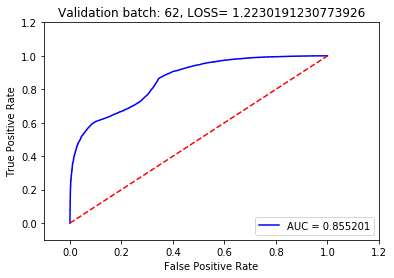

Validation batch: 63, LOSS=1.2354686260223389, ROC_AUC=0.8542830211885413 


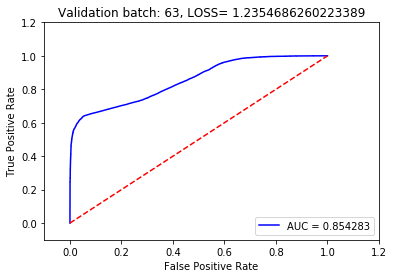

Validation batch: 64, LOSS=1.4022632837295532, ROC_AUC=0.7914301042875117 


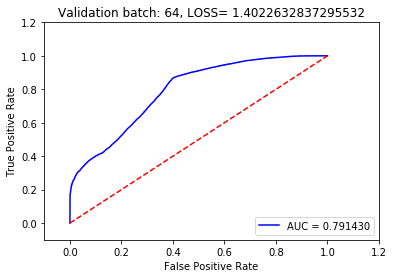

Validation batch: 65, LOSS=1.3541319370269775, ROC_AUC=0.8128444445682897 


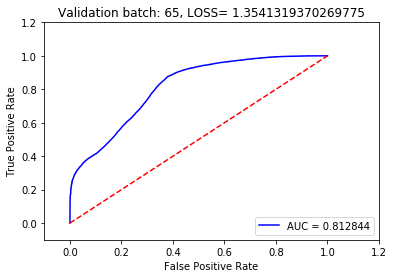

Validation batch: 66, LOSS=1.5917003154754639, ROC_AUC=0.758184996950124 


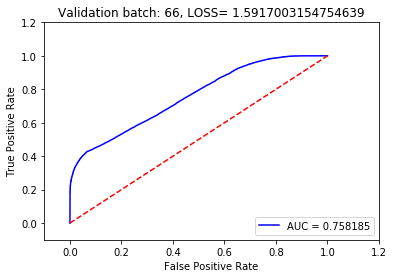

Validation batch: 67, LOSS=1.4263474941253662, ROC_AUC=0.8833592088511004 


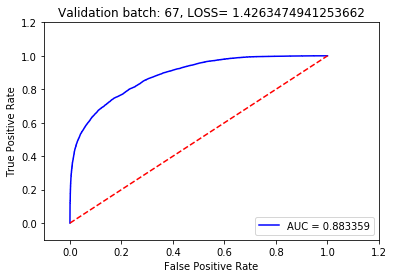

Validation batch: 68, LOSS=1.5119314193725586, ROC_AUC=0.7018832575928688 


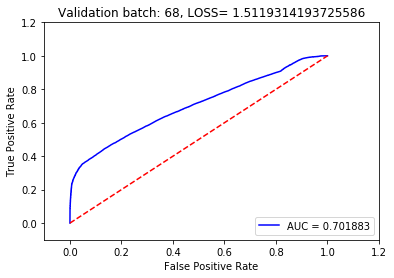

Validation batch: 69, LOSS=2.298259735107422, ROC_AUC=0.7075694655800497 


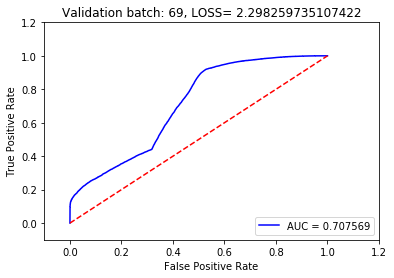

Validation batch: 70, LOSS=1.5542821884155273, ROC_AUC=0.7589099115820203 


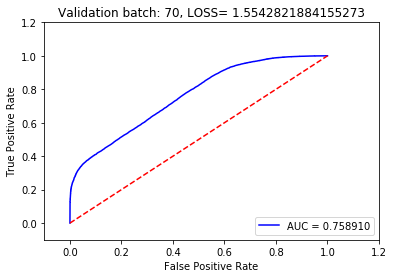

Validation batch: 71, LOSS=1.5238486528396606, ROC_AUC=0.8033613303892698 


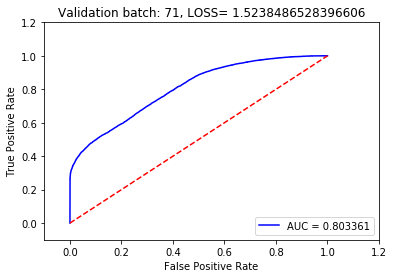

Validation batch: 72, LOSS=1.775960922241211, ROC_AUC=0.768979424998219 


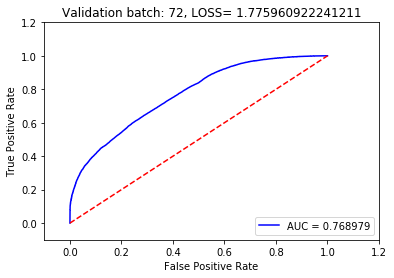

Validation batch: 73, LOSS=1.206290602684021, ROC_AUC=0.7660087224792789 


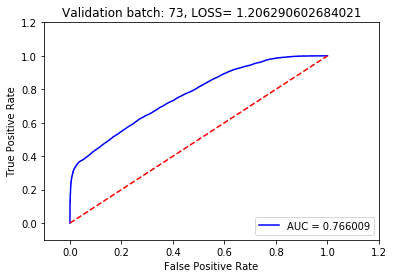

Validation batch: 74, LOSS=1.4727764129638672, ROC_AUC=0.7049522254977341 


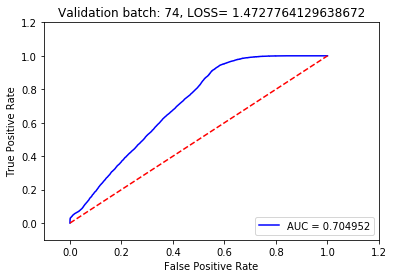

Validation batch: 75, LOSS=1.5403412580490112, ROC_AUC=0.7690761809970013 


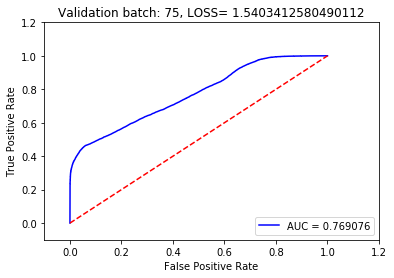

Validation batch: 76, LOSS=1.6868078708648682, ROC_AUC=0.7176269295443611 


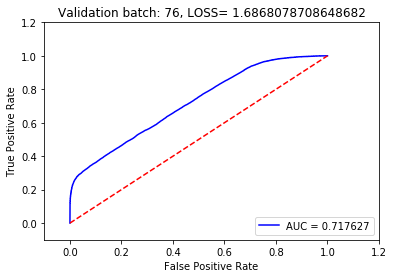

Validation batch: 77, LOSS=1.4477131366729736, ROC_AUC=0.7529862601566799 


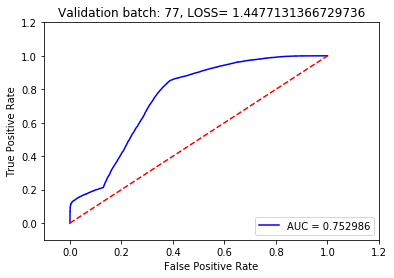

Validation batch: 78, LOSS=1.3340312242507935, ROC_AUC=0.8263983593110413 


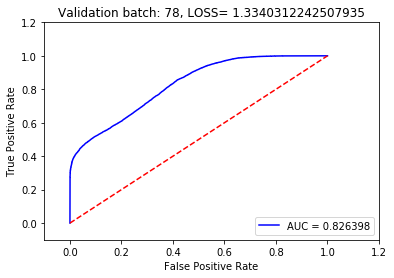

Validation batch: 79, LOSS=1.4118856191635132, ROC_AUC=0.7724924371088822 


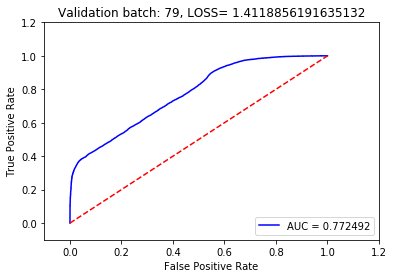

Validation batch: 80, LOSS=1.7524847984313965, ROC_AUC=0.8005647018354652 


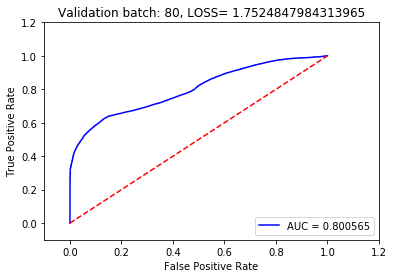

Validation batch: 81, LOSS=1.9124763011932373, ROC_AUC=0.7271569491298936 


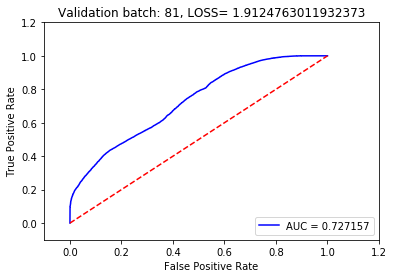

Validation batch: 82, LOSS=2.253643751144409, ROC_AUC=0.7837183892463344 


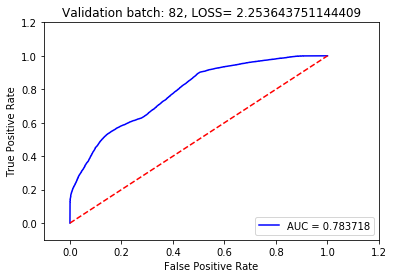

Validation batch: 83, LOSS=1.5979241132736206, ROC_AUC=0.7362462086221688 


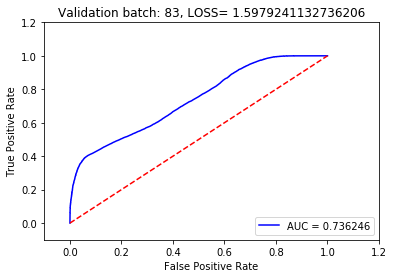

Validation batch: 84, LOSS=1.0567874908447266, ROC_AUC=0.8269528195389885 


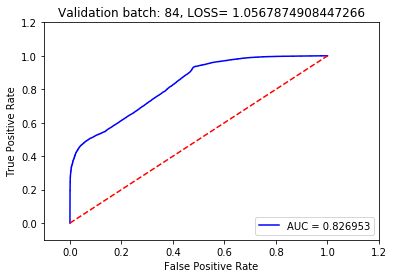

Validation batch: 85, LOSS=1.592942714691162, ROC_AUC=0.706596069207981 


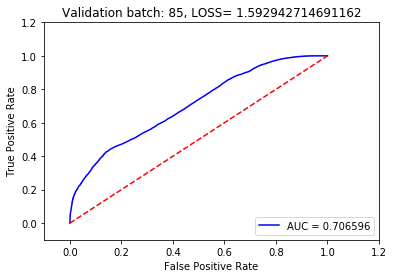

Validation batch: 86, LOSS=1.6849766969680786, ROC_AUC=0.7937625470354436 


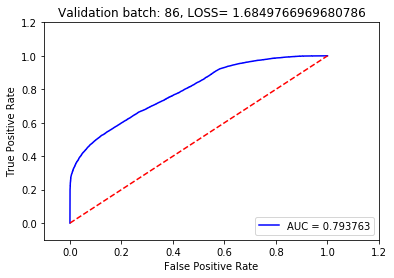

Validation batch: 87, LOSS=2.0671005249023438, ROC_AUC=0.5989170258910843 


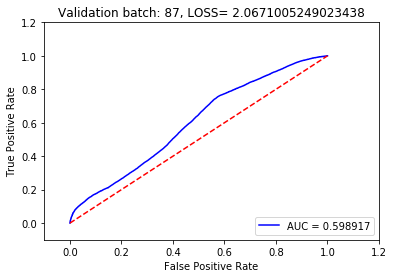

Validation batch: 88, LOSS=1.01448392868042, ROC_AUC=0.8495384996647206 


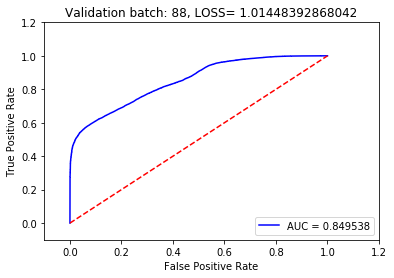

Validation batch: 89, LOSS=1.6774351596832275, ROC_AUC=0.7467471526789672 


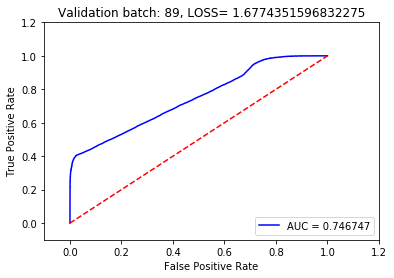

Validation batch: 90, LOSS=1.7379382848739624, ROC_AUC=0.644934637529394 


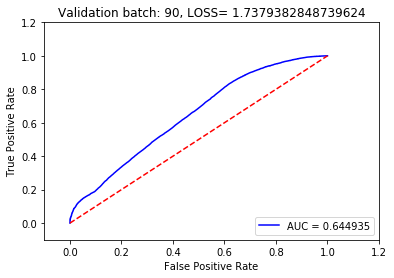

Validation batch: 91, LOSS=1.1294927597045898, ROC_AUC=0.8419970302792203 


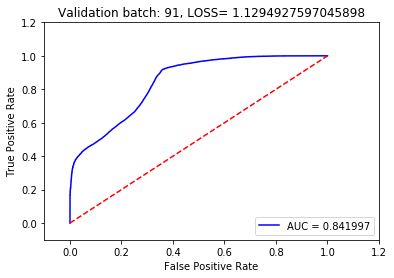

Validation batch: 92, LOSS=1.2940692901611328, ROC_AUC=0.7796466622640803 


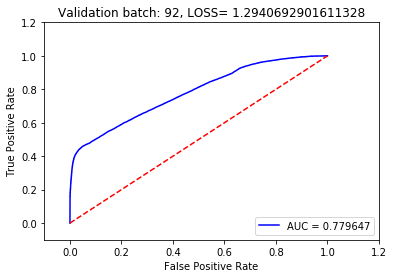

Validation batch: 93, LOSS=1.2902863025665283, ROC_AUC=0.6775944776496691 


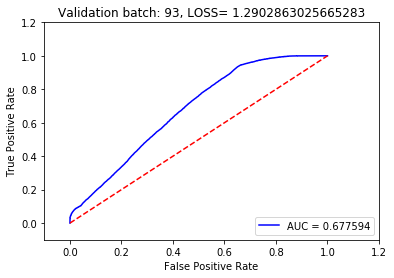

Validation batch: 94, LOSS=1.316677212715149, ROC_AUC=0.6731973924262311 


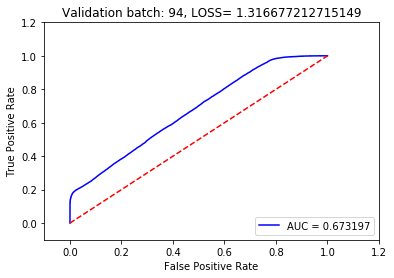

Validation batch: 95, LOSS=1.4284546375274658, ROC_AUC=0.7400893808472618 


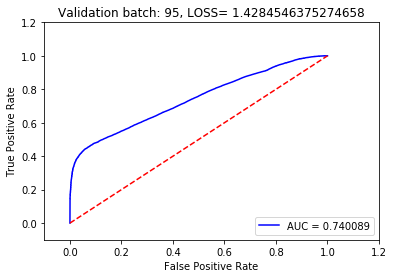

Validation batch: 96, LOSS=1.235167384147644, ROC_AUC=0.7575023479681461 


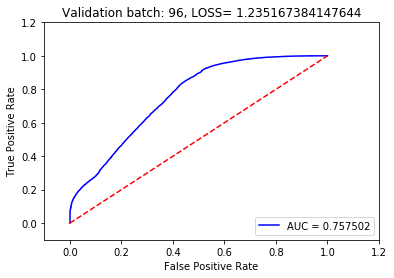

Validation batch: 97, LOSS=1.2943623065948486, ROC_AUC=0.707016293421018 


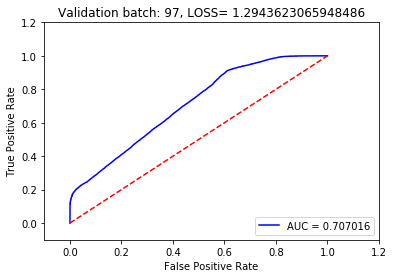

Validation batch: 98, LOSS=1.7934021949768066, ROC_AUC=0.7884152215057776 


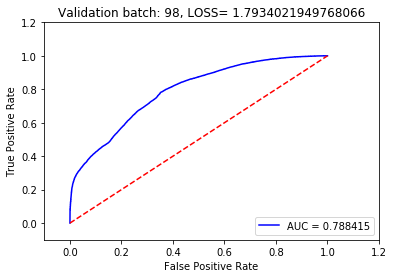

Validation batch: 99, LOSS=1.0633233785629272, ROC_AUC=0.8375612339103884 


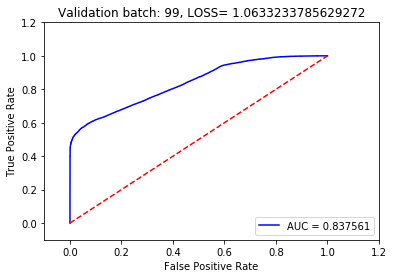

Validation batch: 100, LOSS=1.5100972652435303, ROC_AUC=0.6715650973848334 


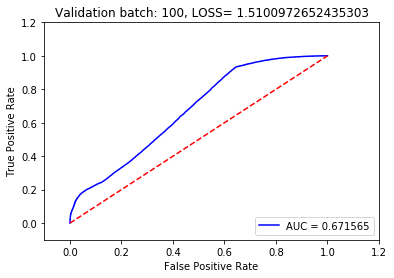

Validation batch: 101, LOSS=0.9057590961456299, ROC_AUC=0.8737998106784446 


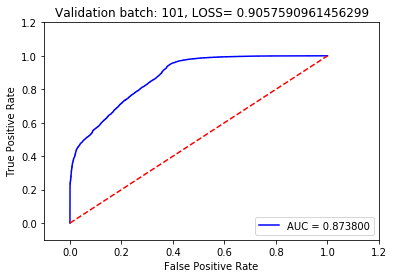

Validation batch: 102, LOSS=1.8700674772262573, ROC_AUC=0.8259883913017587 


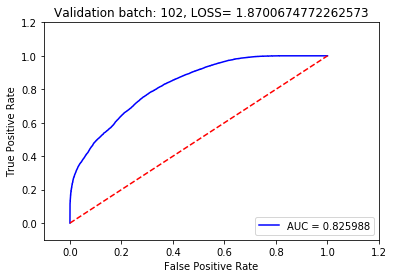

Validation batch: 103, LOSS=1.2613940238952637, ROC_AUC=0.7283264690603883 


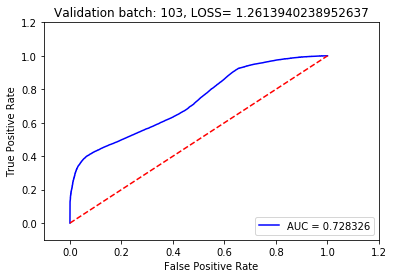

Validation batch: 104, LOSS=1.5003652572631836, ROC_AUC=0.7548914732322259 


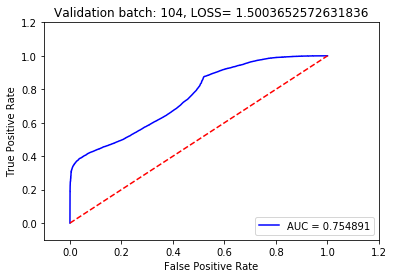

Validation batch: 105, LOSS=1.6517412662506104, ROC_AUC=0.7762263757130234 


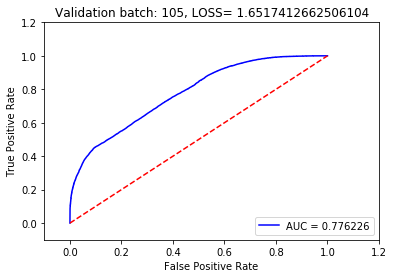

Validation batch: 106, LOSS=1.4242392778396606, ROC_AUC=0.6970069881181244 


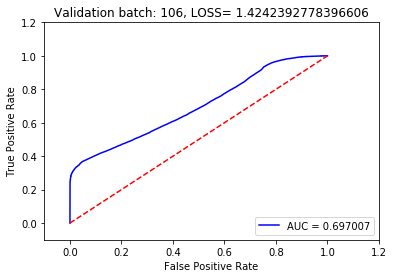

Validation batch: 107, LOSS=1.011056900024414, ROC_AUC=0.8340442915706905 


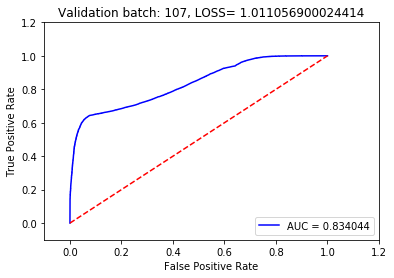

Validation batch: 108, LOSS=2.121150493621826, ROC_AUC=0.7752299044182918 


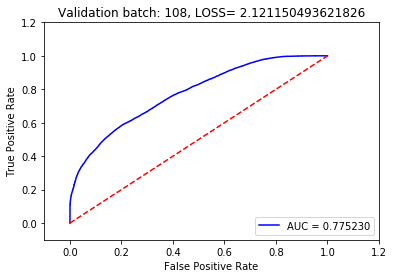

Validation batch: 109, LOSS=1.2107341289520264, ROC_AUC=0.6929792612292645 


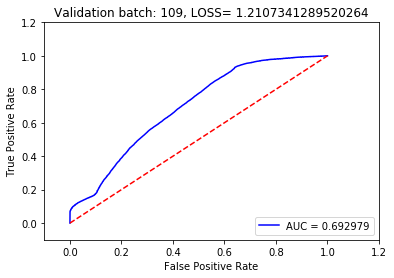

Validation batch: 110, LOSS=1.406653881072998, ROC_AUC=0.853969163299678 


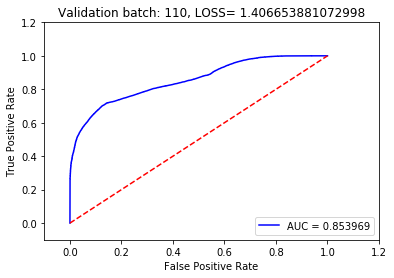

Validation batch: 111, LOSS=1.1610150337219238, ROC_AUC=0.8492545473065727 


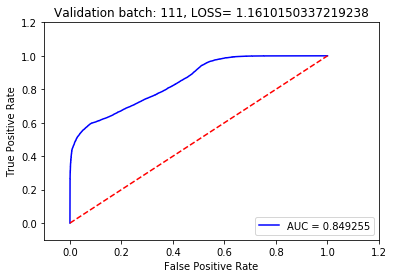

Validation batch: 112, LOSS=1.1356966495513916, ROC_AUC=0.8044503620777351 


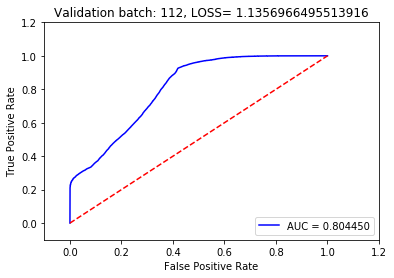

Validation batch: 113, LOSS=1.4719716310501099, ROC_AUC=0.8542831627373372 


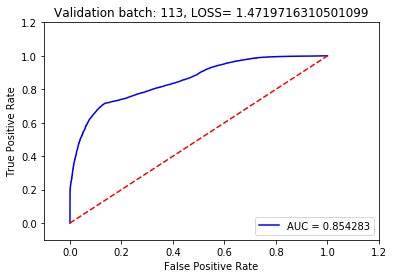

Validation batch: 114, LOSS=1.3888278007507324, ROC_AUC=0.7793234093022796 


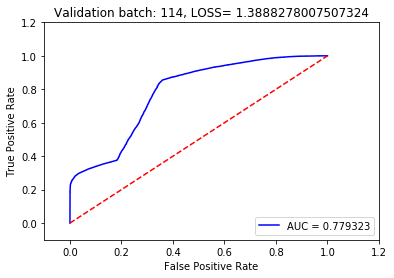

Validation batch: 115, LOSS=1.426891565322876, ROC_AUC=0.7724173748157335 


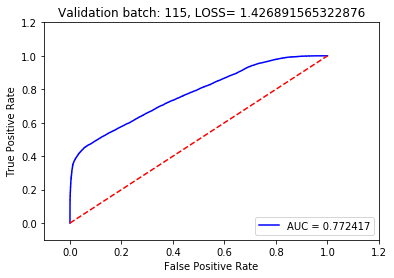

Validation batch: 116, LOSS=0.9583001732826233, ROC_AUC=0.8724979121054989 


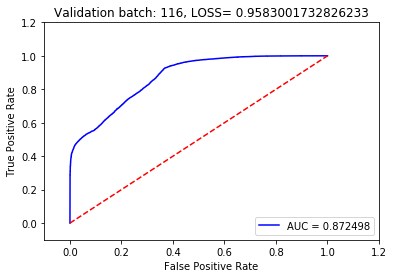

Validation batch: 117, LOSS=1.0734469890594482, ROC_AUC=0.877378979819055 


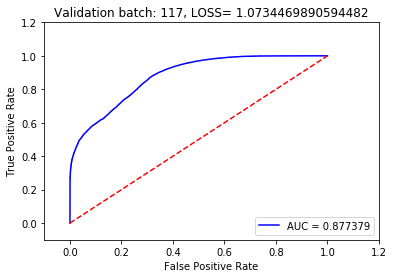

Validation batch: 118, LOSS=1.8054141998291016, ROC_AUC=0.7151999776098308 


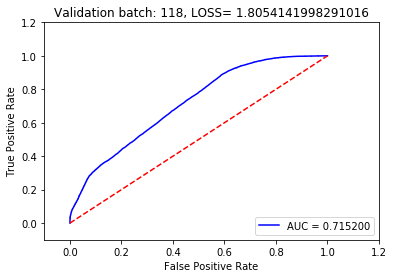

Validation batch: 119, LOSS=1.790796160697937, ROC_AUC=0.7001441327630463 


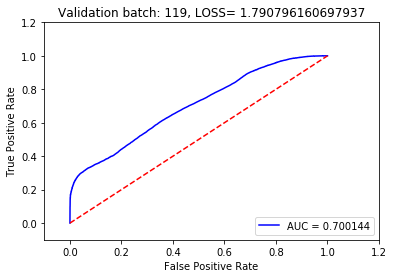

Validation batch: 120, LOSS=1.1573150157928467, ROC_AUC=0.8598261658035726 


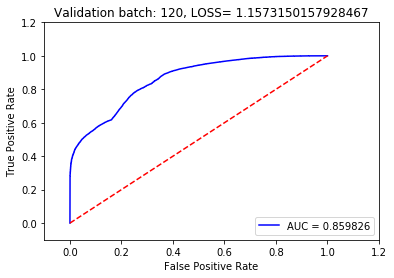

Validation batch: 121, LOSS=1.5392526388168335, ROC_AUC=0.7946464237718553 


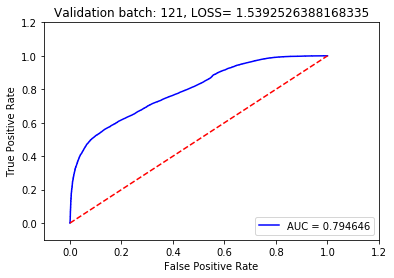

Validation batch: 122, LOSS=1.5246009826660156, ROC_AUC=0.8200805998102214 


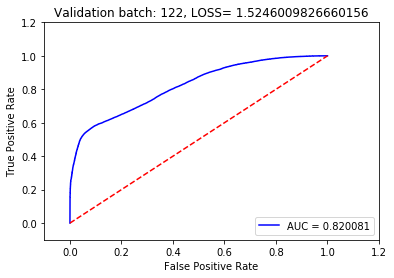

Validation batch: 123, LOSS=2.4855692386627197, ROC_AUC=0.7500014340284961 


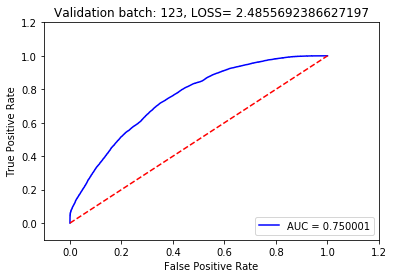

Validation batch: 124, LOSS=1.340078592300415, ROC_AUC=0.724841171249039 


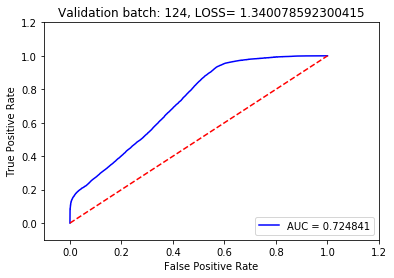

In [25]:
##### Validation data
## ground truth
gt_dl_val = DataLoader(gt_dataset_val, batch_size=bsize, shuffle=False)


## DG
dg_dl_val = DataLoader(dg_dataset_val, batch_size=bsize, shuffle=False)


# define a zipped object for iterating
zl = zip(dg_dl_val, gt_dl_val)

# some lists for plotting all batch ROC curves
all_fpr = []
all_tpr = []
all_thresh = []
all_roc_auc = []
for i_val, (inputs_, targets_) in enumerate(zl):

        # get the inputs
        #inputs, targets = variable(inputs_).cuda(), variable(targets_).cuda()
        inputs, targets = variable(inputs_), variable(targets_)
        inputs.to(device)
        targets.to(device)

        # evaluate
        outputs = model(inputs)
        
        # record loss
        v_loss = criterion(outputs, targets)
        
        # convert to numpy and get ROC params
        pred_y_val = outputs.cpu().data.numpy().squeeze().flatten()
        #pred_y_val[pred_y_val > 0] = 1.
        #pred_y_val[pred_y_val <=0] = 0.
        target_y_val = targets.cpu().data.numpy().flatten()
        tu = (v_loss, roc_auc_score(target_y_val,pred_y_val ))
        print ('Validation batch: {}, LOSS={}, ROC_AUC={} '.format(i_val, *tu))  

        # calculate FPR and TPR, and area-under-curve
        false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y_val,pred_y_val)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        
        # append to lists
        all_fpr.append(false_positive_rate)
        all_tpr.append(true_positive_rate)
        all_thresh.append(thresholds)
        all_roc_auc.append(roc_auc)

        plt.title('Validation batch: {}, LOSS= {}'.format(i_val, v_loss))
        plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([-0.1, 1.2])
        plt.ylim([-0.1, 1.2])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()





/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


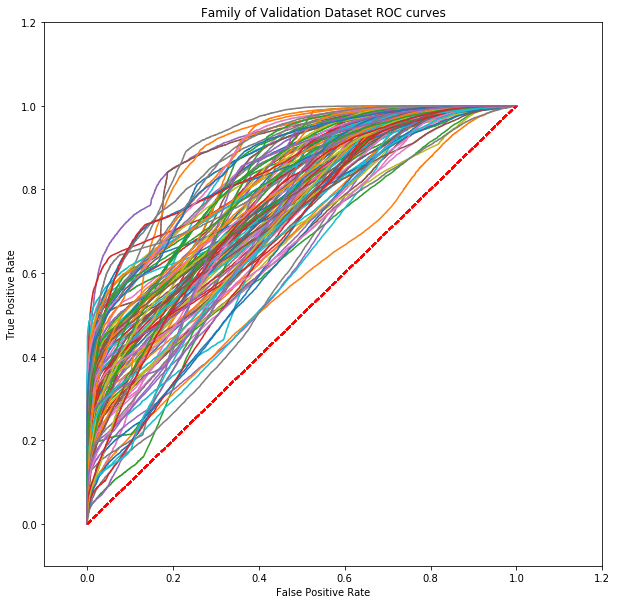

In [26]:
## plot all the validation dataset ROC curves
plt.figure(figsize=(10,10))
plt.title('Family of Validation Dataset ROC curves')
for ind in range(len(all_fpr)):
    
    plt.plot(all_fpr[ind], all_tpr[ind])
    #plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
#     plt.yscale('log')
#     plt.xscale('log')
    
plt.show()

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


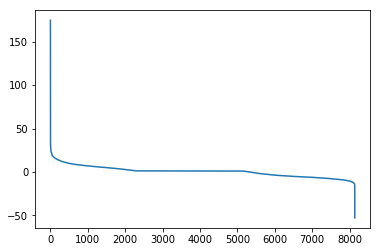

In [27]:
plt.plot(all_thresh[0])

In [28]:
model_path = 'runs/debug/for_paper/MS2_model_e{}_b{}_no_aug_GPUPAR.pt'.format(epoch_i, bsize)
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))

save(epoch)

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


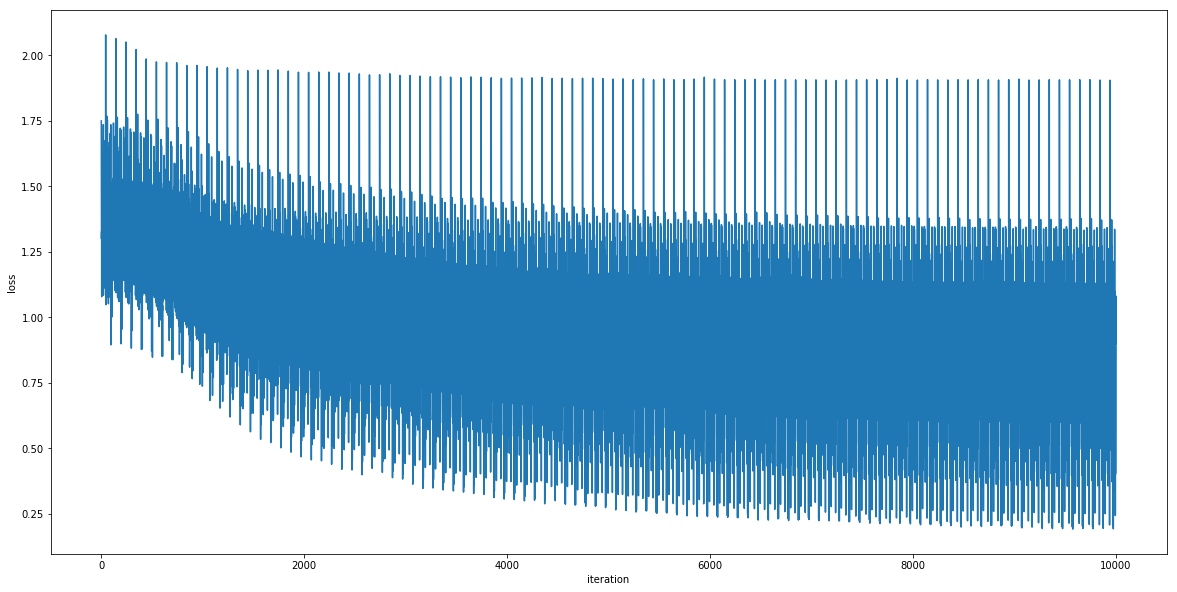

In [29]:
# plot the losses epoch losses from the last 66/100 epochs
# (forgot to record from epoch 0 since I was going in epoch chunks... it is faster with the GPU!!)
plt.figure(figsize=(20,10))
plt.plot([l.data.cpu().numpy() for l in losses])
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

# plt.plot([l.data.cpu().numpy() for l in losses_ep])
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.show()

/home/ubuntu/segmentation/IS_segmentation/utils.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return cuda(Variable(x, volatile=volatile))
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


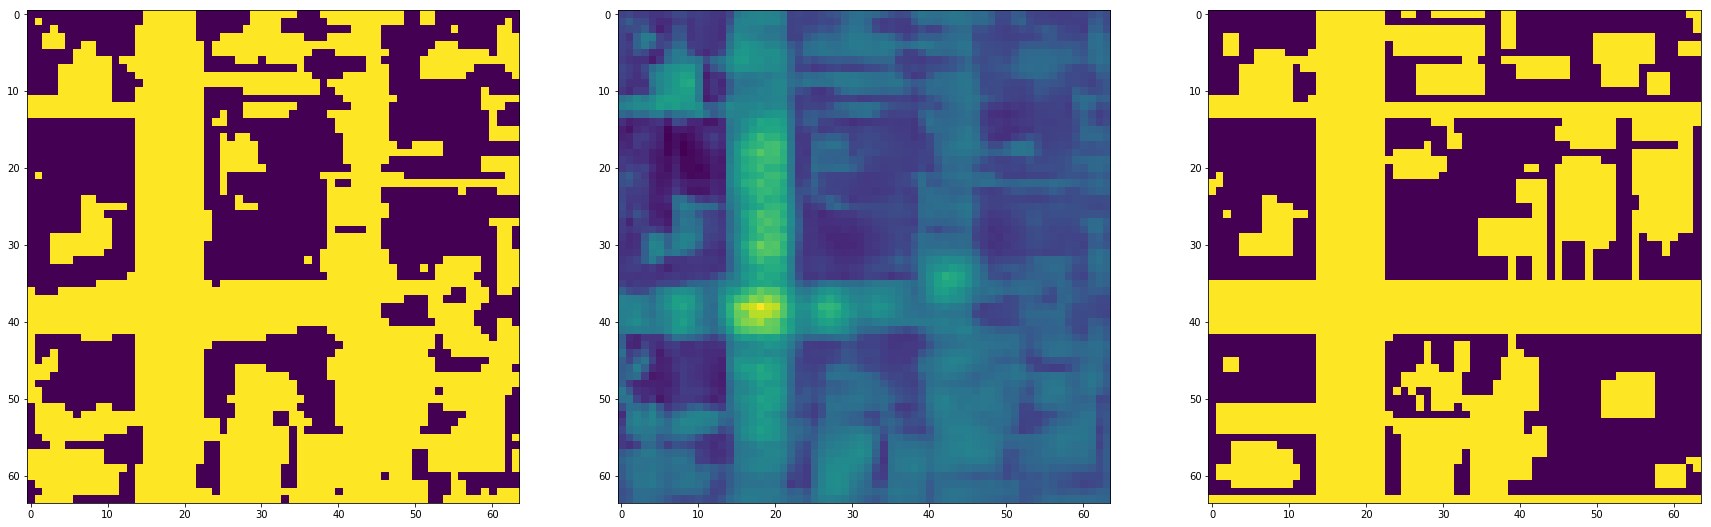

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


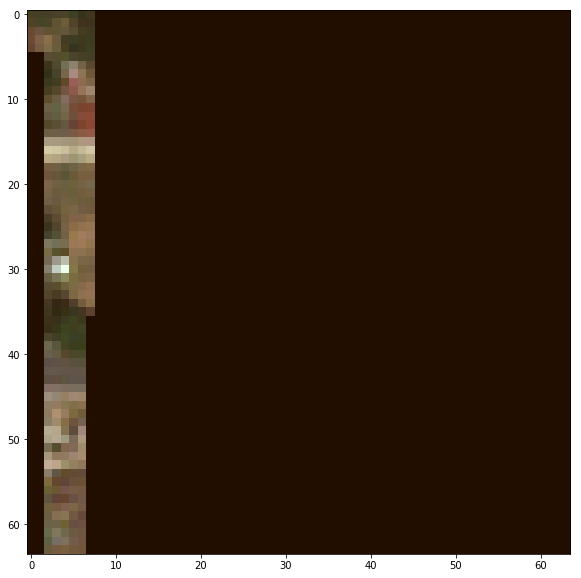

invalid argument 3: Source tensor must be contiguous at /opt/conda/conda-bld/pytorch_1532576276790/work/aten/src/THC/generic/THCTensorCopy.cpp:114


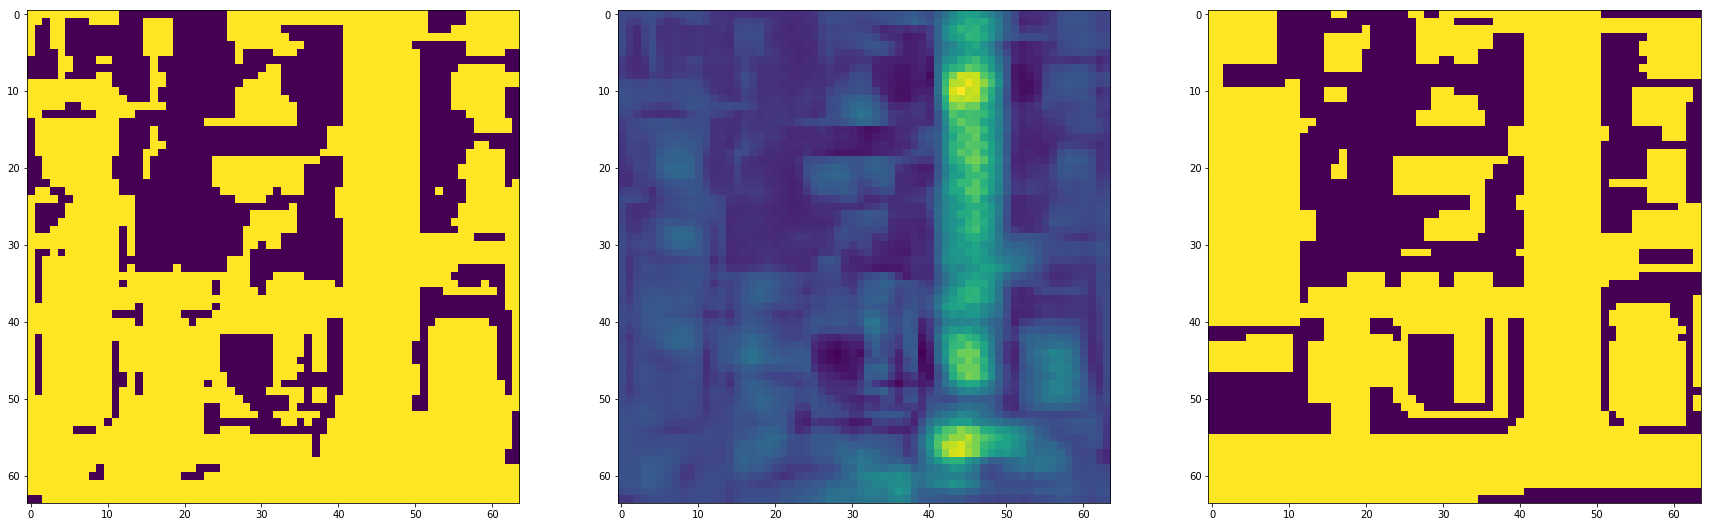

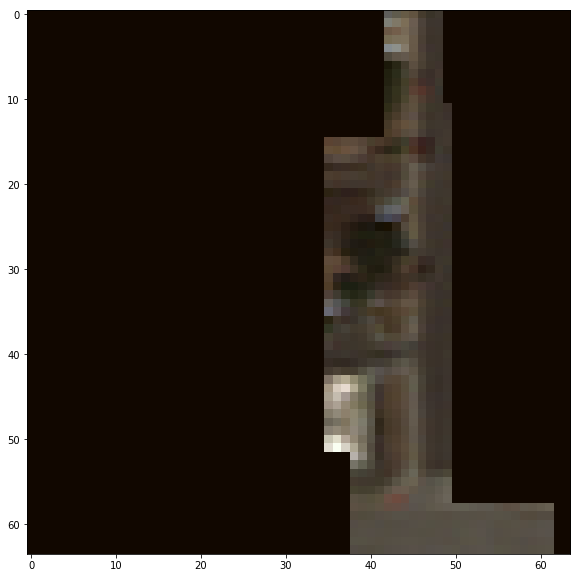

invalid argument 3: Source tensor must be contiguous at /opt/conda/conda-bld/pytorch_1532576276790/work/aten/src/THC/generic/THCTensorCopy.cpp:114


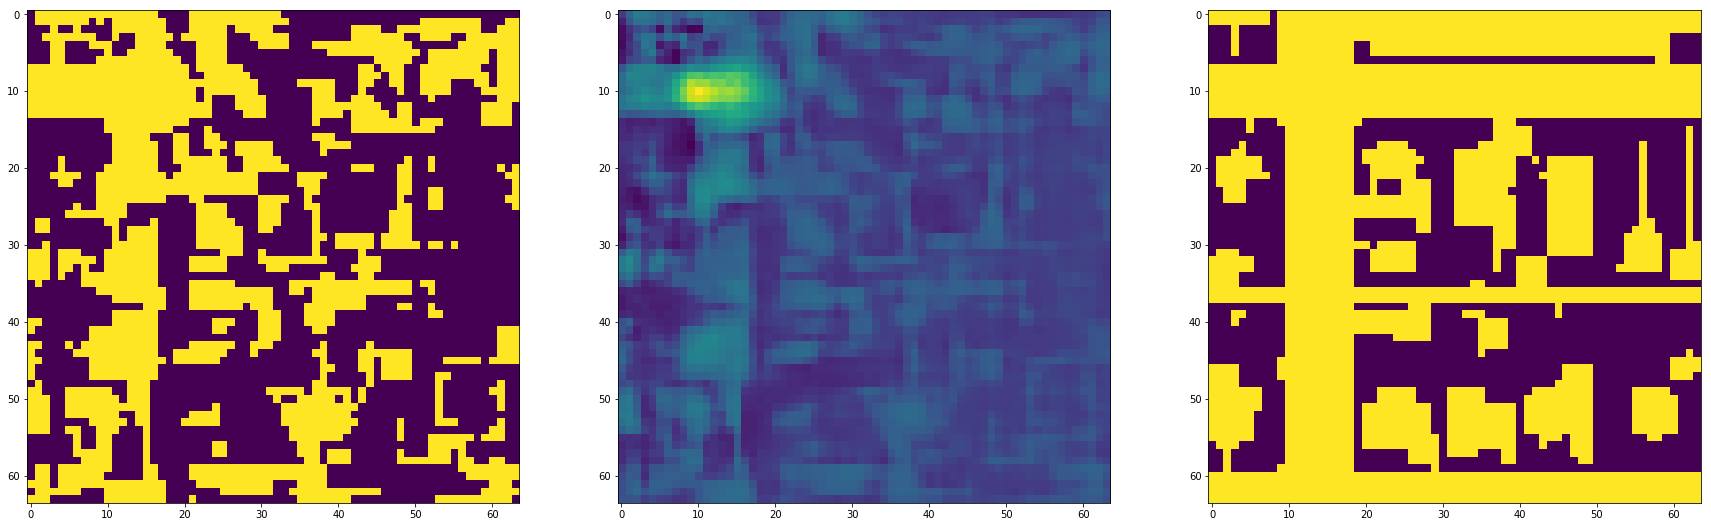

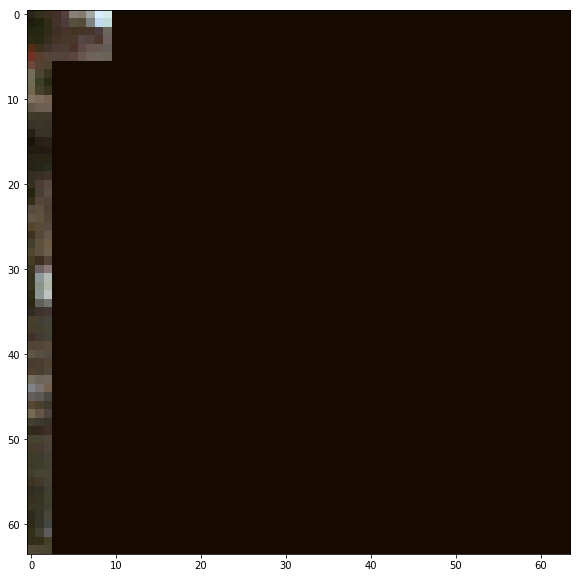

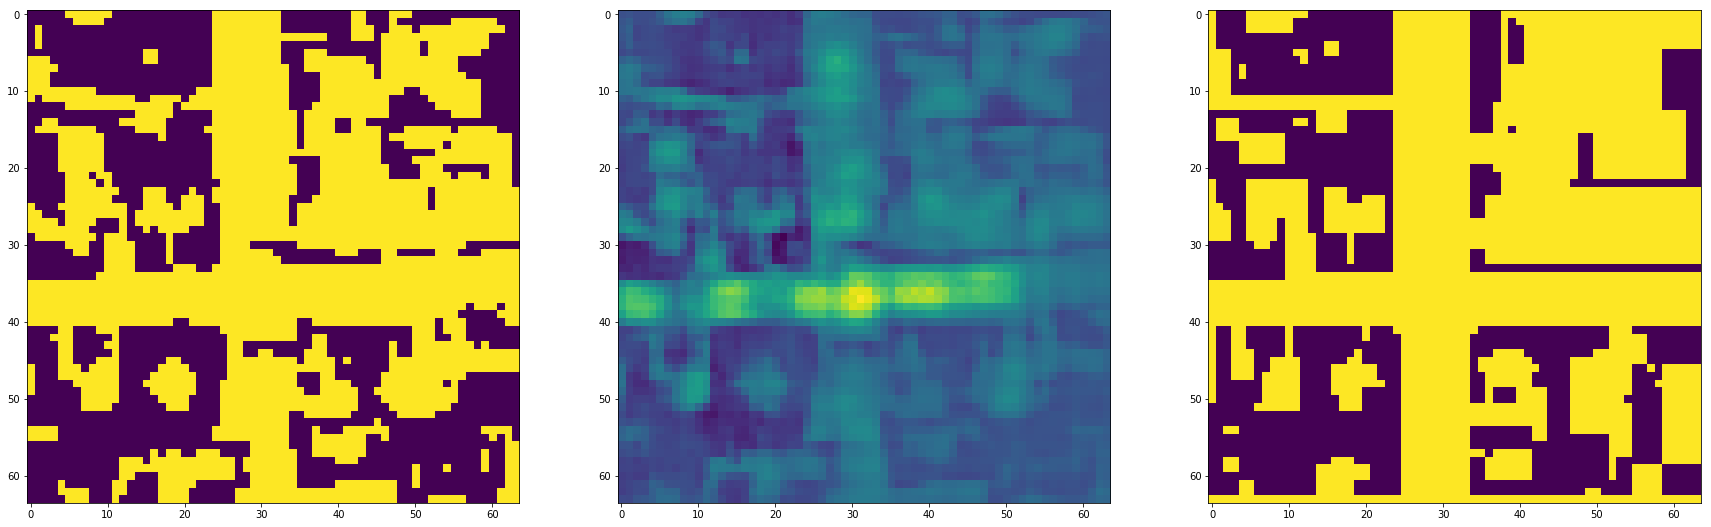

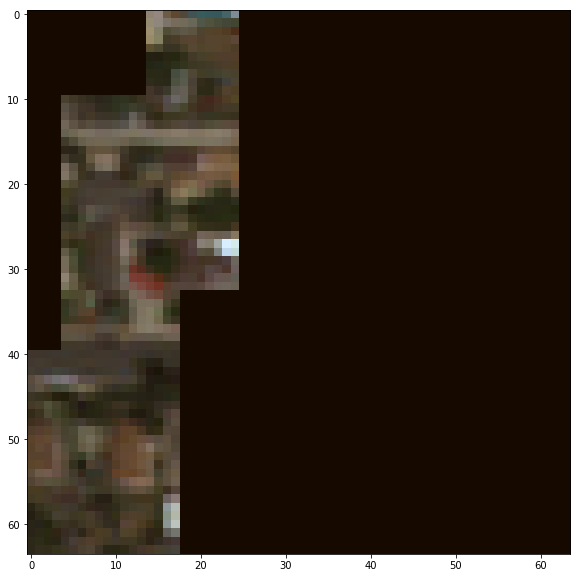

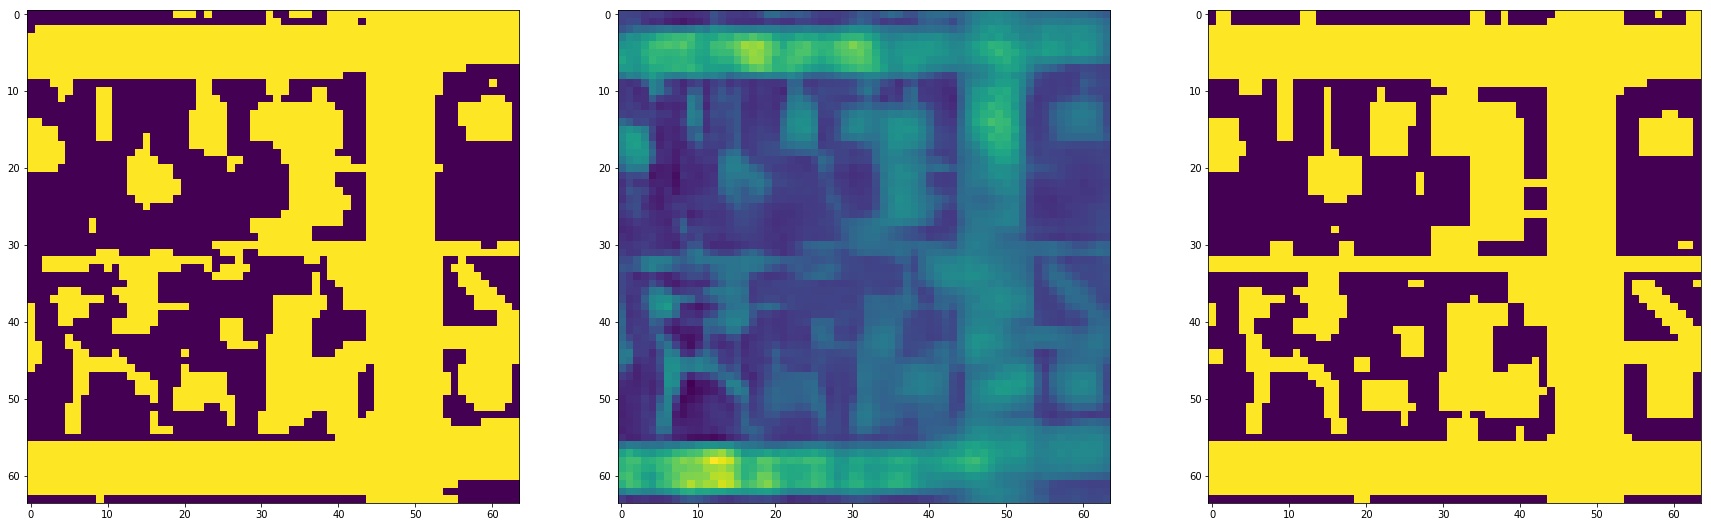

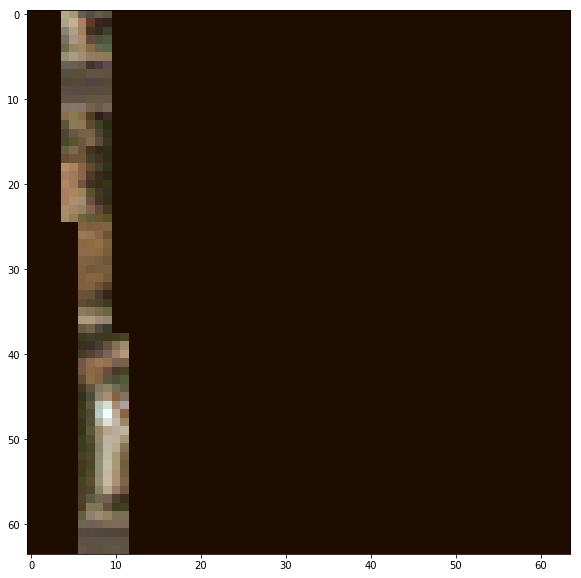

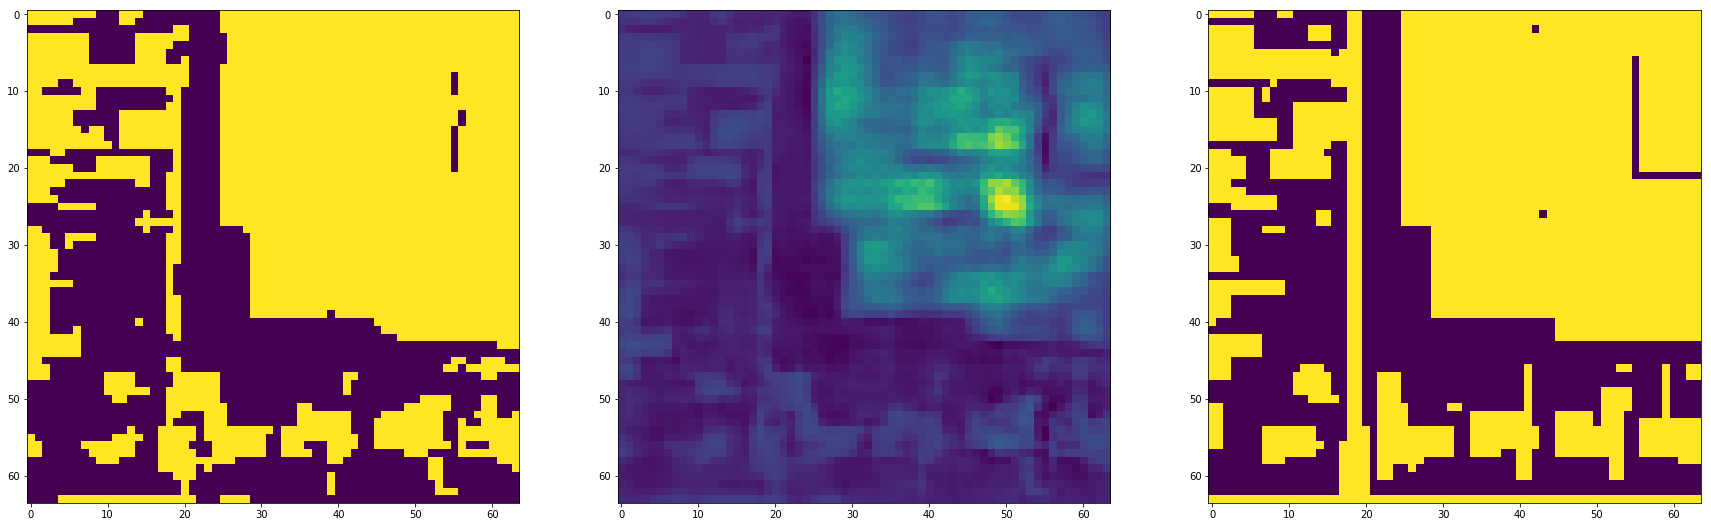

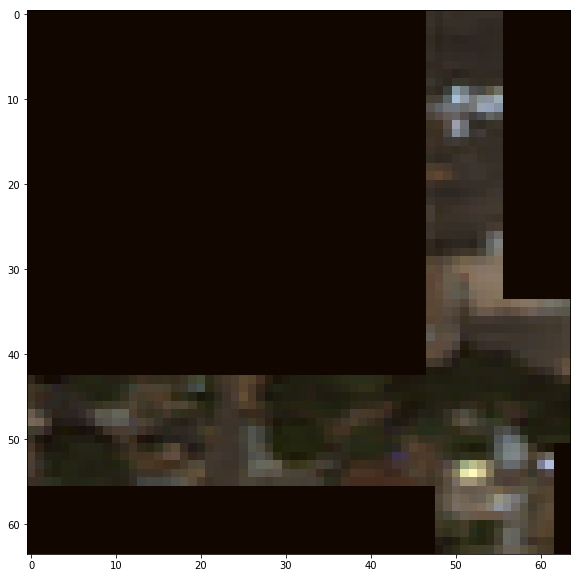

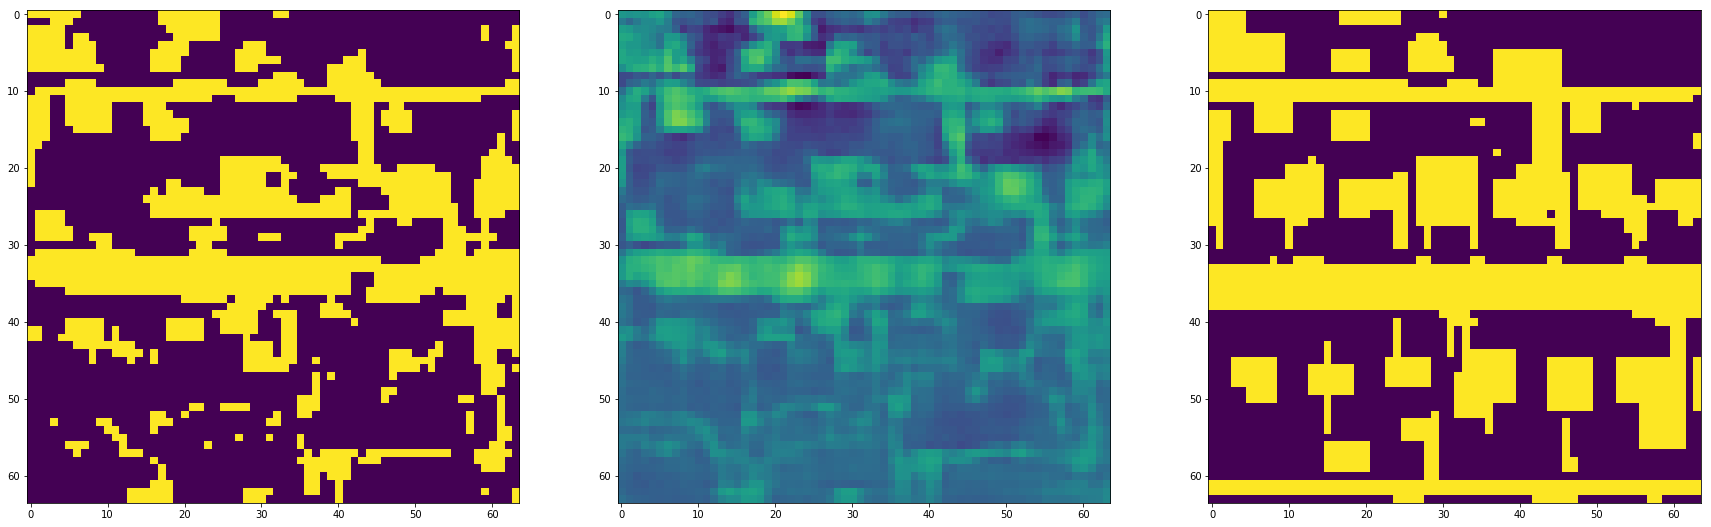

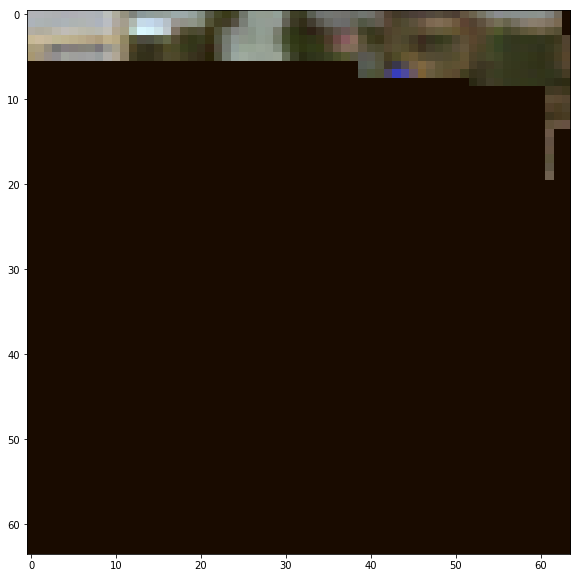

invalid argument 3: Source tensor must be contiguous at /opt/conda/conda-bld/pytorch_1532576276790/work/aten/src/THC/generic/THCTensorCopy.cpp:114


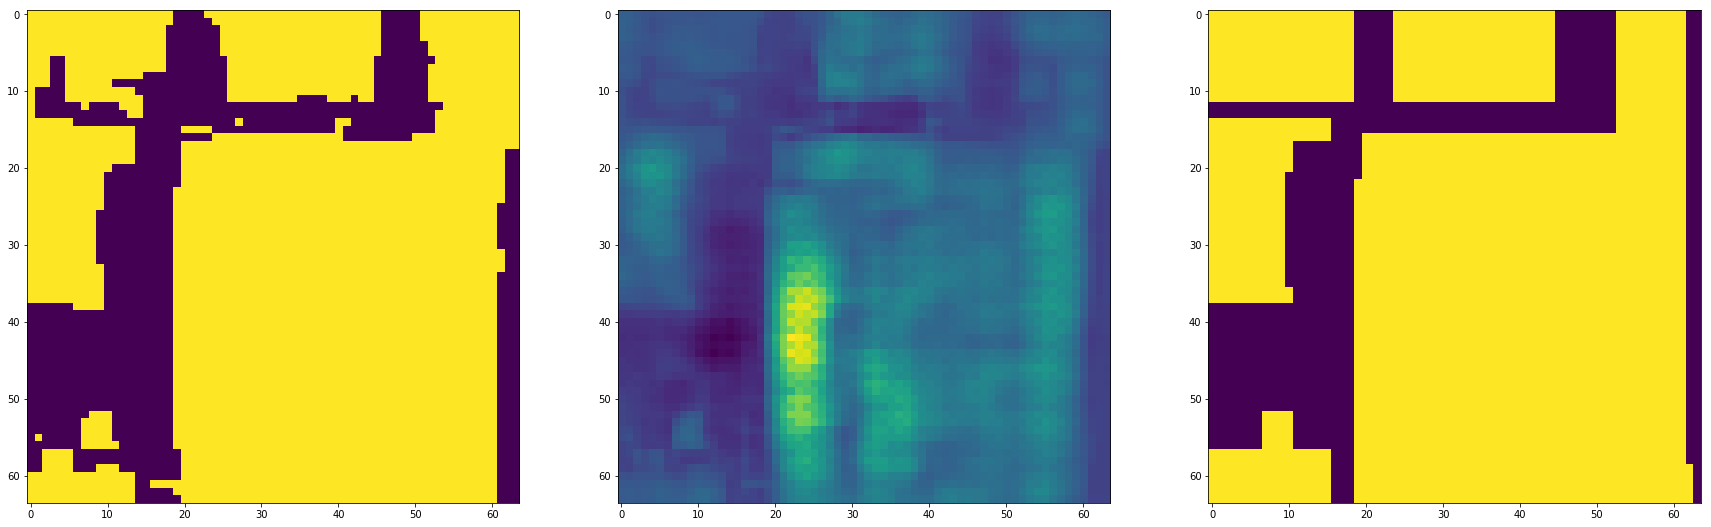

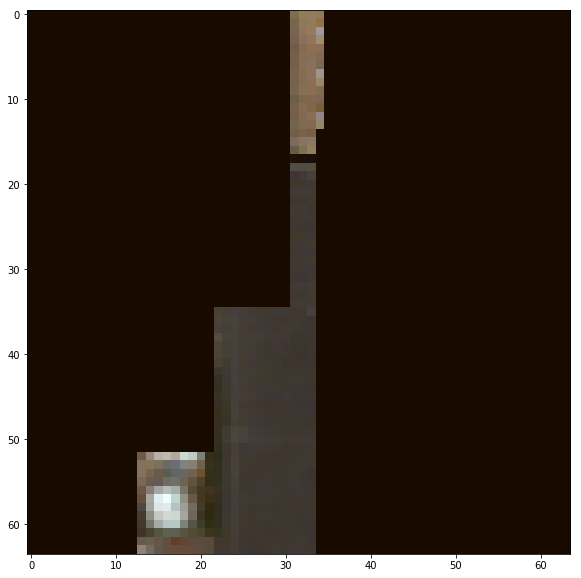

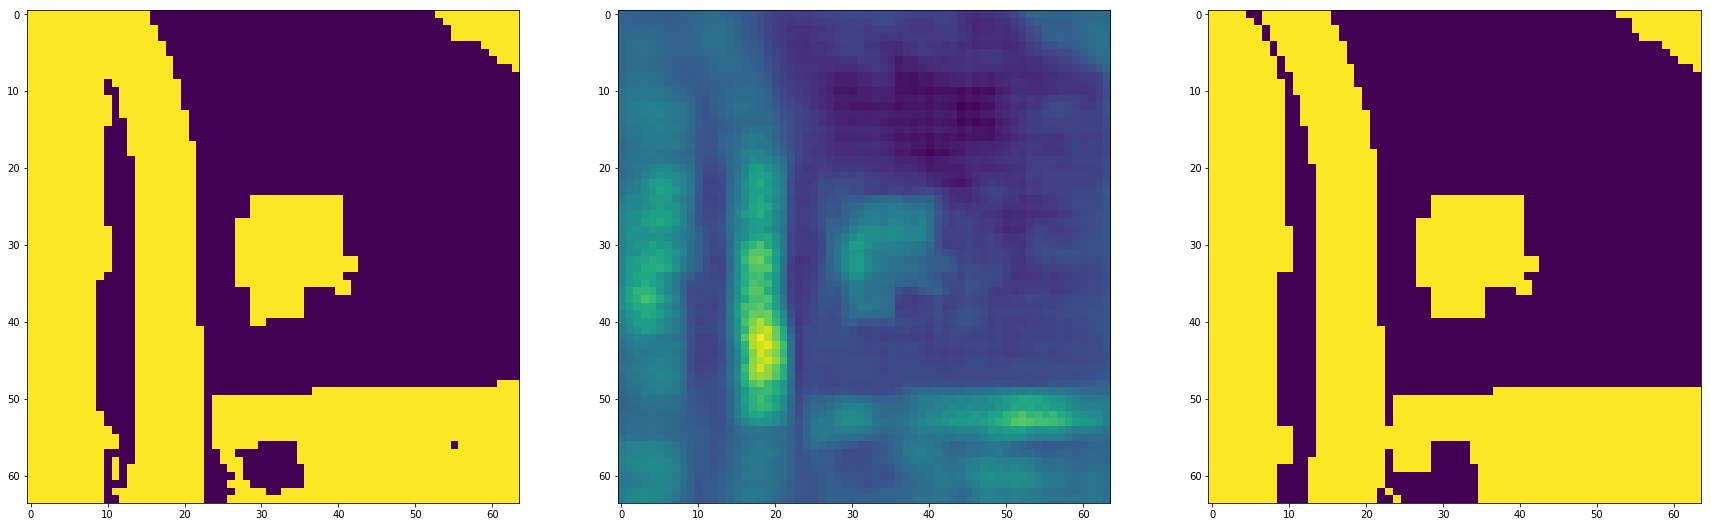

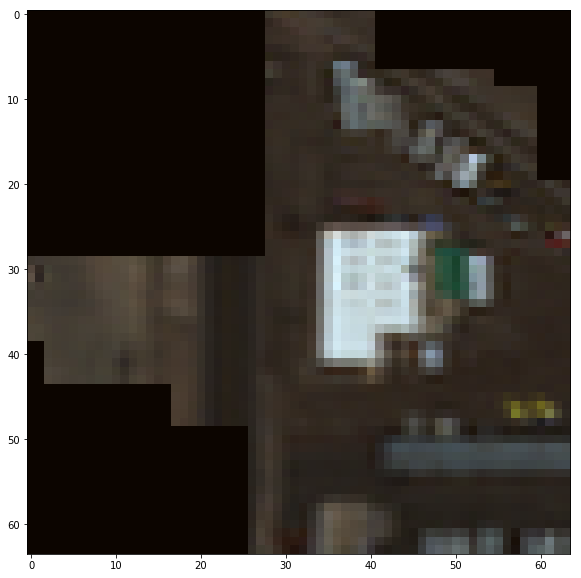

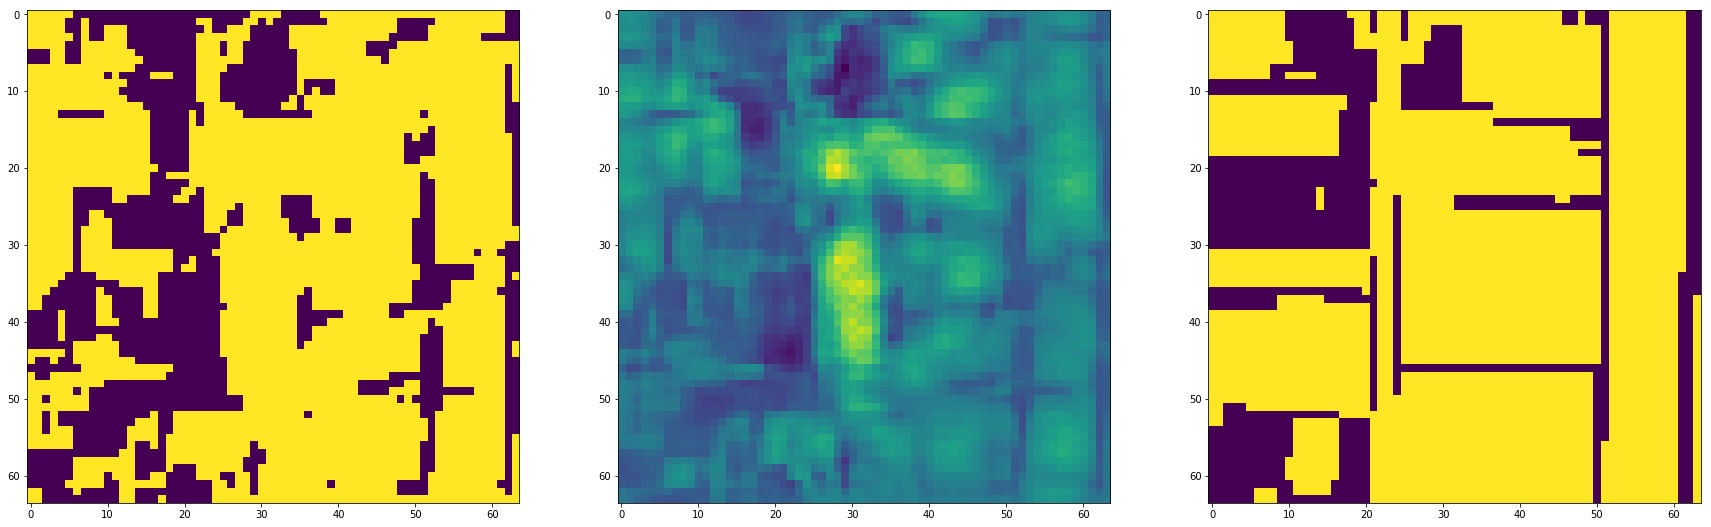

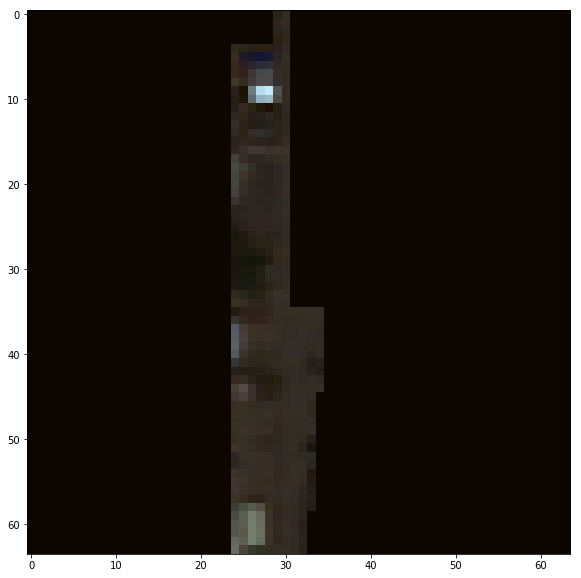

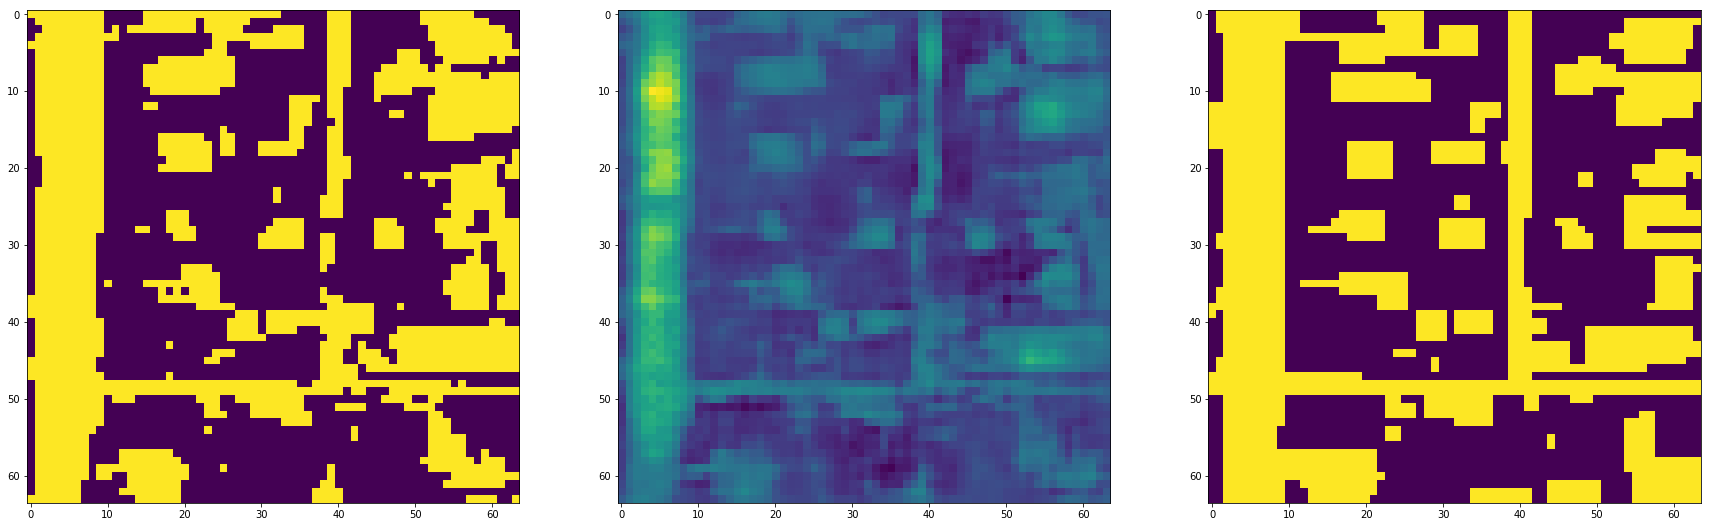

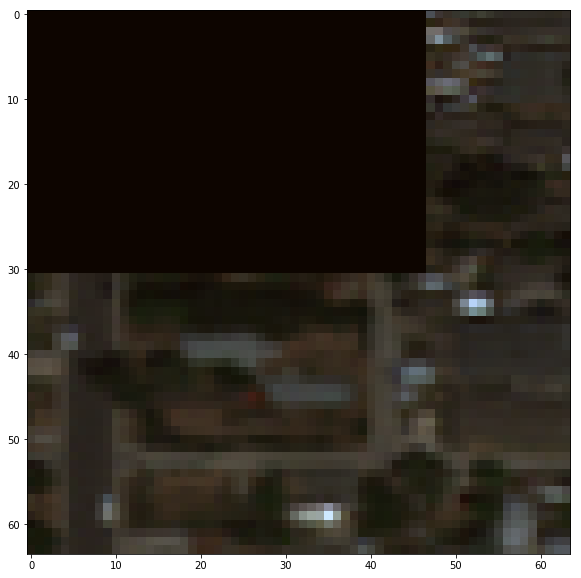

In [30]:
# check one of the test images
test_inds = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]
for test_ind in test_inds:
    
    try:
        input_img = torch.unsqueeze(variable(dg_dataset_test[test_ind], volatile=True), dim=0) 
        mask = model(input_img)


        mask_im = mask.squeeze().data.cpu().numpy()
        mask_binary = mask_im.copy()

        fig, ax = plt.subplots(1,3, figsize=(30,10))
        thresh = 0
        mask_binary[mask_im<=thresh] = 0
        mask_binary[mask_im>thresh] = 1
        ax[0].imshow(mask_binary)
        # ax[0].colorbar()
        ax[1].imshow(mask_im)
        gt_im = gt_dataset_test[test_ind].numpy().squeeze()
        ax[2].imshow(gt_im)
        # ax[1].colorbar()
        plt.show()

        fig = plt.figure(figsize=(10,10))
        source_im = dg_dataset_test[test_ind].numpy()
        plt.imshow(misc.bytescale(np.rollaxis(source_im[[4,2,1],:,:], 0, 3)))
        plt.show()
    
    except Exception as e:
        print(e)
        pass


In [ ]:
# # temp code to keep running overnight
# timeout = time.time() + 60*60*12   # 5 hours from now
# while True:
#     test = 0
#     time.sleep(1)
#     if test == 5 or time.time() > timeout:
#         break
#     test = test - 1

In [ ]:
# # save current state
# save = lambda ep: torch.save({
#         'model': model.state_dict(),
#         'epoch': ep,
#         'step': step,
#     }, str(model_path))

# root = Path('runs/debug')
# model_path = root / 'model_e{}_s{}.pt'.format(epoch, step)
# ep=epoch
# step=i

# save(ep)

In [ ]:
# #load model
# if model_path.exists():
#     state = torch.load(str(model_path))
#     epoch = state['epoch']
#     step = state['step']
#     model.load_state_dict(state['model'])
#     print('Restored model, epoch {}, step {:,}'.format(epoch, step))